# 10-2_TEST_Library_characterization

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/10_TEST_Library_Characterization2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 1. DATA wrangling



LCMS data



- Tidy strictosidine data

In [8]:
import pandas as pd
import numpy as np

In [9]:
# Lets read in plate 53 and 54

plate53 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/2nd_library_lcms/Result_table_210927_tmet576_yp53.csv", sep = ',')
plate54 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/2nd_library_lcms/Result_table_211001_tmet581_yp54.csv", sep = ',')


# Stack the DataFrames on top of each other - Lets add the plate 49 from before
unprocessed_lcms_results = pd.concat([ plate53, plate54 ], axis=0)
unprocessed_lcms_results

,data_file,sample_notes,Amt_ug_L_Loganin,Amt_ug_L_Secologanin,Amt_ug_L_Strictosidine,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine
0,210927_TMET576_016.xms,96WP1232_A1,NaN,NaN,1351.268,180064.781,NaN,NaN,2.546823,1123.859574
1,210927_TMET576_017.xms,96WP1232_A2,NaN,NaN,4203.014,146340.297,NaN,NaN,7.921696,913.370971
2,210927_TMET576_018.xms,96WP1232_A3,NaN,NaN,NaN,144634.984,NaN,NaN,NaN,902.727400
3,210927_TMET576_019.xms,96WP1232_A4,586.062,NaN,11989.688,131989.250,1.501260,NaN,22.597750,823.800087
4,210927_TMET576_020.xms,96WP1232_A5,1812.931,NaN,17870.656,130796.781,4.644016,NaN,33.681995,816.357390
...,...,...,...,...,...,...,...,...,...,...
77,211001_TMET581_114.xms,96WP1248_H8,1526.662,NaN,15091.814,167400.484,3.910708,NaN,28.444529,1044.816402
78,211001_TMET581_115.xms,96WP1248_H9,965.164,NaN,11963.110,130024.117,2.472371,NaN,22.547656,811.534871
79,211001_TMET581_116.xms,96WP1248_H10,1988.074,NaN,20066.662,190289.266,5.092664,NaN,37.820951,1187.674860
80,211001_TMET581_117.xms,96WP1248_H11,5787.284,NaN,18192.010,159843.375,14.824745,NaN,34.287672,997.649326


In [10]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = unprocessed_lcms_results.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:5], inplace = True, axis = 1)
df_filter

#df_filter
## saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()
#
## split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates = df_filter_plates[[0,1]]
df_filter_plates.columns = ['plate', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()
#
## Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

##add 0 to all nan positions 
concatenated = concatenated.fillna(0)


### Changing the names of the plates to yp53/54
concatenated.loc[concatenated['plate'] == '96WP1232', 'plate'] = 'yp53'
concatenated.loc[concatenated['plate'] == '96WP1248', 'plate'] = 'yp54'

# Change name
lcms_results = concatenated
lcms_results

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A1
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A2
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A3
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A4
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A5
...,...,...,...,...,...,...,...,...,...
77,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H8
78,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H9
79,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10
80,211001_TMET581_117.xms,96WP1248_H11,159843.375,14.824745,0.0,34.287672,997.649326,yp54,H11


In [11]:
## changing the well names to incorporate a 0 between the first wells

In [12]:
well_list = lcms_results['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

lcms_results['well'] = new_well_list
lcms_results

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A01
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A02
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A03
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A04
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A05
...,...,...,...,...,...,...,...,...,...
77,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H08
78,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H09
79,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10
80,211001_TMET581_117.xms,96WP1248_H11,159843.375,14.824745,0.0,34.287672,997.649326,yp54,H11


## 1.1 Merge Plate design with yp53-54 metadata into single csv file


In [13]:
# importing xls file
xls = pd.ExcelFile('ConStrain_on_google_colab/Data/raw/023_LC-MS/excel_files/plateDesign_yp53-54_MIA-HA-111-145.xlsx')

# reading the different sheets
df1 = pd.read_excel(xls, 'yp53_reallocated')  # plate 53
df1["plate"] = 'yp53' 

df2 = pd.read_excel(xls, '111-115_121-125_136-140-145yp54') # plate 54
df2["plate"] = 'yp54' 


df2

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Unnamed: 12,plate
0,A01,MIA-HA-111_1,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-111,VminG8H CroCPR,NaN,yp54
1,A02,MIA-HA-111_2,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-111,VminG8H CroCPR,NaN,yp54
2,A03,MIA-HA-111_3,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-111,VminG8H CroCPR,NaN,yp54
3,A04,MIA-HA-111_4,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-111,VminG8H CroCPR,NaN,yp54
4,A05,MIA-HA-112_1,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-112,SmusG8H CroCPR,NaN,yp54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,H08,20210922MIA-CH-A2_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,2.0,MIA-CH-A2,NaN,yp54,yp54
92,H09,20210922MIA-CH-A2_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,3.0,MIA-CH-A2,NaN,yp54,yp54
93,H10,20210922MIA-CH-A2_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,4.0,MIA-CH-A2,NaN,yp54,yp54
94,H11,20210922MIA-CM-3_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,1.0,MIA-CM-3,NaN,yp54,yp54


In [14]:
results_merged = pd.concat([df1, df2], ignore_index=True)

In [15]:
results_merged

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Date of sampling,old position,plate,Unnamed: 12
0,A01,20210922MIA-HA-116_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A01,yp53,NaN
1,A02,20210922MIA-HA-116_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A02,yp53,NaN
2,A03,20210922MIA-HA-116_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A03,yp53,NaN
3,A04,20210922MIA-HA-116_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A04,yp53,NaN
4,A05,20210922MIA-HA-117_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-117,SmusG8H AanCPR,20210922.0,A05,yp53,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,H08,20210922MIA-CH-A2_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,2.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
188,H09,20210922MIA-CH-A2_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,3.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
189,H10,20210922MIA-CH-A2_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,4.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
190,H11,20210922MIA-CM-3_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,1.0,MIA-CM-3,NaN,NaN,NaN,yp54,yp54


In [16]:
results_merged.to_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp53-54_meta_LL.csv', header = True, index = False)

In [17]:
# read into a dataframe
PlateDesign = pd.read_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp53-54_meta_LL.csv') 
PlateDesign

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Date of sampling,old position,plate,Unnamed: 12
0,A01,20210922MIA-HA-116_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A01,yp53,NaN
1,A02,20210922MIA-HA-116_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A02,yp53,NaN
2,A03,20210922MIA-HA-116_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A03,yp53,NaN
3,A04,20210922MIA-HA-116_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A04,yp53,NaN
4,A05,20210922MIA-HA-117_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-117,SmusG8H AanCPR,20210922.0,A05,yp53,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,H08,20210922MIA-CH-A2_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,2.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
188,H09,20210922MIA-CH-A2_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,3.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
189,H10,20210922MIA-CH-A2_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,4.0,MIA-CH-A2,NaN,NaN,NaN,yp54,yp54
190,H11,20210922MIA-CM-3_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Moeller Pedersen,1.0,MIA-CM-3,NaN,NaN,NaN,yp54,yp54


In [18]:
# we take the columns that we are interested in
PlateDesign= PlateDesign[['plate','position','Strain', 'Replicate #', 'Genotype', 'Medium']]
# rename them
PlateDesign.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign

,plate,well,strain,col_no,genotype,medium
0,yp53,A01,MIA-HA-116,1.0,VminG8H AanCPR,YPD
1,yp53,A02,MIA-HA-116,2.0,VminG8H AanCPR,YPD
2,yp53,A03,MIA-HA-116,3.0,VminG8H AanCPR,YPD
3,yp53,A04,MIA-HA-116,4.0,VminG8H AanCPR,YPD
4,yp53,A05,MIA-HA-117,1.0,SmusG8H AanCPR,YPD
...,...,...,...,...,...,...
187,yp54,H08,MIA-CH-A2,2.0,NaN,YPD
188,yp54,H09,MIA-CH-A2,3.0,NaN,YPD
189,yp54,H10,MIA-CH-A2,4.0,NaN,YPD
190,yp54,H11,MIA-CM-3,1.0,NaN,YPD


In [19]:
# Merge our lcms file with the genotype/strain 
lcms_platedesign = pd.merge(lcms_results, PlateDesign, left_on=['plate','well'], right_on = ['plate','well'])
lcms_platedesign

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A01,MIA-HA-116,1.0,VminG8H AanCPR,YPD
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A02,MIA-HA-116,2.0,VminG8H AanCPR,YPD
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A03,MIA-HA-116,3.0,VminG8H AanCPR,YPD
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A04,MIA-HA-116,4.0,VminG8H AanCPR,YPD
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A05,MIA-HA-117,1.0,SmusG8H AanCPR,YPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H08,MIA-CH-A2,2.0,NaN,YPD
164,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H09,MIA-CH-A2,3.0,NaN,YPD
165,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10,MIA-CH-A2,4.0,NaN,YPD
166,211001_TMET581_117.xms,96WP1248_H11,159843.375,14.824745,0.0,34.287672,997.649326,yp54,H11,MIA-CM-3,1.0,NaN,YPD


## 1.2 YP53+54

*** Experiment
1. Check if MIA-HA-x strains produces MIA's 

Strains  
1. YP53

Media feed: 0.2 mM geraniol & 1 mM tryptamine
1. YP + 2 % glucose + feed


Cultivation 30C, 300 rpm 
1. (d-2): Inoculate precultures. Transfer 20 of YP48 g.stock to 80 media 1 (-feed). 
2. (d0):  Inoculate maincultures. Transfer 10 of preculture to  500 media 1 and media 2
3. (e6): transfer 180 ul -> analytics filter and add standard
    6. Measure MIAs (extracellular loganin)
4. (TBD): Khem run plate
5. (TBD): Data analysis


*** Experiment:
- Strains: 4 colonies from each of 35 library plates. Each plate has specific combination of G8H and CPR but any of 4 possible promoter combinations
- Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
- Sampling: day 6

In [20]:
control_strict_df = lcms_platedesign.loc[lcms_platedesign['strain'] == 'MIA-CH-A2']
df_mean = control_strict_df["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df

28.176771442499998


,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium
81,210927_TMET576_117.xms,96WP1232_H7,148983.953,2.317657,0.0,26.227450,929.871133,yp53,H07,MIA-CH-A2,1.0,NaN,YPD
82,210927_TMET576_118.xms,96WP1232_H8,137948.813,3.038375,0.0,30.908774,860.996211,yp53,H08,MIA-CH-A2,2.0,NaN,YPD
83,210927_TMET576_119.xms,96WP1232_H9,132422.063,3.245648,0.0,32.612530,826.501454,yp53,H09,MIA-CH-A2,3.0,NaN,YPD
84,210927_TMET576_120.xms,96WP1232_H10,119852.172,2.673744,0.0,22.711625,748.047510,yp53,H10,MIA-CH-A2,4.0,NaN,YPD
162,211001_TMET581_113.xms,96WP1248_H7,147344.984,2.050766,0.0,24.140656,919.641643,yp54,H07,MIA-CH-A2,1.0,NaN,YPD
163,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H08,MIA-CH-A2,2.0,NaN,YPD
164,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H09,MIA-CH-A2,3.0,NaN,YPD
165,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10,MIA-CH-A2,4.0,NaN,YPD


In [21]:
controls = control_strict_df.groupby(['plate']).mean()
controls

,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,col_no
plate,,,,,,
yp53,134801.75025,2.818856,0.0,28.115095,841.354077,2.5
yp54,158764.71275,3.381627,0.0,28.238448,990.916944,2.5


In [22]:
control_yp53 = controls.loc['yp53', 'Amt_uM_Strictosidine']
control_yp54 = controls.loc['yp54', 'Amt_uM_Strictosidine']


## 1.3 Normalize strictosidine productions

In [23]:
# make a copy and a new row
norm_strict_df = lcms_platedesign.copy()
norm_strict_df['norm_strict_%'] = 0

for index, row in norm_strict_df.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate'] == 'yp53': 
        normalized = ((row['Amt_uM_Strictosidine']/control_yp53)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
    if row['plate'] == 'yp54':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp54)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
   

In [24]:
# Sort the data
sorted_df = norm_strict_df.sort_values(by='norm_strict_%', ascending=False)
sorted_df = sorted_df.reset_index()


# Lets remove Mia-CM3 - the control
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df #[sorted_df['strain'] != 'MIA-CH-A2' ]

sorted_df_lcms

,index,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,norm_strict_%
1,44,210927_TMET576_063.xms,96WP1232_D9,124164.867,7.054980,0.0,47.692027,774.964842,yp53,D09,MIA-HA-132,1.0,SmusG8H RseCPR,YPD,169.631396
2,29,210927_TMET576_047.xms,96WP1232_C6,151006.359,8.910505,0.0,44.848557,942.493815,yp53,C06,MIA-HA-128,2.0,RsepG8H CloCPR,YPD,159.517718
3,6,210927_TMET576_022.xms,96WP1232_A7,131414.891,7.860359,0.0,44.719792,820.215273,yp53,A07,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,159.059724
4,49,210927_TMET576_083.xms,96WP1232_E2,148120.250,5.506115,0.0,40.809806,924.480402,yp53,E02,MIA-HA-133,2.0,RsepG8H RseCPR,YPD,145.152656
5,13,210927_TMET576_030.xms,96WP1232_B2,133004.656,5.139113,0.0,40.761943,830.137661,yp53,B02,MIA-HA-119,2.0,CroG8H AanCPR,YPD,144.982414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,74,210927_TMET576_110.xms,96WP1232_G3,211609.719,0.000000,0.0,0.000000,1320.744720,yp53,G03,MIA-HA-144,3.0,CroG8H AniCPR,YPD,0.000000
164,75,210927_TMET576_111.xms,96WP1232_G4,186587.766,0.000000,0.0,0.000000,1164.572251,yp53,G04,MIA-HA-144,4.0,CroG8H AniCPR,YPD,0.000000
165,76,210927_TMET576_112.xms,96WP1232_G5,184884.563,0.000000,0.0,0.000000,1153.941849,yp53,G05,n.ctr(36),1.0,NaN,YPD,0.000000
166,86,210927_TMET576_122.xms,96WP1232_H12,138742.094,0.000000,0.0,0.000000,865.947410,yp53,H12,BLANK,1.0,NaN,YPD,0.000000


## 1.4 Plotting plate 53

NameError: name 'plt' is not defined

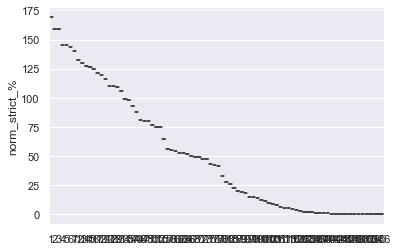

In [25]:
# Plotting plate 53
plate53 = sorted_df_lcms.loc[sorted_df_lcms['plate'] == 'yp53']

import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x=plate53.index, y='norm_strict_%',data=plate53)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

## 1.5 Plotting plate 54

In [ ]:
# Plotting plate 53
plate54 = sorted_df_lcms.loc[sorted_df_lcms['plate'] == 'yp54']

import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x=plate54.index, y='norm_strict_%',data=plate54)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x='genotype', y='norm_strict_%',data=sorted_df_lcms)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

In [ ]:
histogram = sns.barplot(data=sorted_df_lcms, x=sorted_df_lcms.index, y='norm_strict_%')
histogram.axhline(100)

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)
# this makes sure the labels are not shown
None

In [ ]:
histogram = sns.barplot(data=sorted_df_lcms, x='genotype', y='norm_strict_%')
histogram.axhline(100)

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)
# this makes sure the labels are not shown
None


# 1.6 2nd Analytics
**Experiment**


Due to large deviations in the data found, the LC-MS was run on all sample again

In [ ]:
# Lets read in plate 53 and 54

plate55 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/2nd_library_lcms/Result_table_211111_tmet601_96wp1334.csv", sep = ',')
plate56 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/2nd_library_lcms/Result_table_211111_tmet601_96wp1335.csv", sep = ',')


# Stack the DataFrames on top of each other - Lets add the plate 49 from before
unprocessed_lcms_results2 = pd.concat([ plate55, plate56 ], axis=0)
unprocessed_lcms_results2

In [ ]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = unprocessed_lcms_results2.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:5], inplace = True, axis = 1)
df_filter

#df_filter
## saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()
#
## split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates = df_filter_plates[[0,1]]
df_filter_plates.columns = ['plate', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()
#
## Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

##add 0 to all nan positions 
concatenated = concatenated.fillna(0)


### Changing the names of the plates to yp53/54
concatenated.loc[concatenated['plate'] == '96WP1334', 'plate'] = 'yp55'
concatenated.loc[concatenated['plate'] == '96WP1335', 'plate'] = 'yp56'

# Change name
lcms_results2 = concatenated
lcms_results2

In [ ]:
## changing the well names to incorporate a 0 between the first wells

In [ ]:
well_list = lcms_results2['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

lcms_results2['well'] = new_well_list
lcms_results2

In [ ]:
# importing xls file
xls = pd.ExcelFile('ConStrain_on_google_colab/Data/raw/023_LC-MS/excel_files/plateDesign_yp53-54_MIA-HA-111-145.xlsx')


#xls = pd.ExcelFile('/Users/lucaslevassor/Desktop/g8h_cpr_library 2/data/raw/023_LC-MS/plateDesign_yp53-54_MIA-HA-111-145.xlsx')

# reading the different sheets
df3 = pd.read_excel(xls, 'YP55')  # plate 53
df3["plate"] = 'yp55' 

df4 = pd.read_excel(xls, 'YP56') # plate 54
df4["plate"] = 'yp56' 


df4['Old plate'] = df4['old pos'] 
df4['old pos'] = df4['Illustrate'] 


In [ ]:
results_merged2 = pd.concat([df3, df4], ignore_index=True)

In [ ]:
results_merged2['well'] = results_merged2['position']

In [26]:
results_merged2.tail(50)

NameError: name 'results_merged2' is not defined

In [27]:
results_merged2.to_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp55-56_meta_LL.csv', header = True, index = False)

NameError: name 'results_merged2' is not defined

In [185]:
# read into a dataframe
PlateDesign1 = pd.read_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp55-56_meta_LL.csv') 
PlateDesign1

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Old plate,old pos,Illustrate,plate,Unnamed: 15,Unnamed: 16,well
0,A01,MIA-HA-111_1,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-111,VminG8H CroCPR,54.0,A01,54_A01,yp55,NaN,NaN,A01
1,A02,MIA-HA-111_2,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-111,VminG8H CroCPR,54.0,A02,54_A02,yp55,NaN,NaN,A02
2,A03,MIA-HA-111_3,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-111,VminG8H CroCPR,54.0,A03,54_A03,yp55,NaN,NaN,A03
3,A04,MIA-HA-111_4,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-111,VminG8H CroCPR,54.0,A04,54_A04,yp55,NaN,NaN,A04
4,A05,MIA-HA-112_1,Extracellular Region,SC-UT,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-112,SmusG8H CroCPR,54.0,A05,54_A05,yp55,NaN,NaN,A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,H08,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp56,yp56,yp,H08
188,H09,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp56,yp56,yp,H09
189,H10,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp56,yp56,yp,H10
190,H11,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp56,yp56,yp,H11


In [186]:
#pd.set_option('display.max_rows', 100)

In [187]:
# we take the columns that we are interested in
PlateDesign1= PlateDesign1[['plate','position','Strain', 'Replicate #', 'Genotype', 'Medium','Old plate', 'old pos' ]]
# rename them
PlateDesign1.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium', 'old plate', 'old pos']
PlateDesign1

,plate,well,strain,col_no,genotype,medium,old plate,old pos
0,yp55,A01,MIA-HA-111,1.0,VminG8H CroCPR,SC-UT,54.0,A01
1,yp55,A02,MIA-HA-111,2.0,VminG8H CroCPR,SC-UT,54.0,A02
2,yp55,A03,MIA-HA-111,3.0,VminG8H CroCPR,SC-UT,54.0,A03
3,yp55,A04,MIA-HA-111,4.0,VminG8H CroCPR,SC-UT,54.0,A04
4,yp55,A05,MIA-HA-112,1.0,SmusG8H CroCPR,SC-UT,54.0,A05
...,...,...,...,...,...,...,...,...
187,yp56,H08,NaN,NaN,NaN,NaN,NaN,NaN
188,yp56,H09,NaN,NaN,NaN,NaN,NaN,NaN
189,yp56,H10,NaN,NaN,NaN,NaN,NaN,NaN
190,yp56,H11,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
lcms_results2

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,211111_TMET601_019.xms,96WP1334_A1,163260.391,0.000000,0.0,4.666623,1018.976351,yp55,A01
1,211111_TMET601_020.xms,96WP1334_A2,174690.391,0.808043,0.0,7.298172,1090.315760,yp55,A02
2,211111_TMET601_021.xms,96WP1334_A3,201708.188,1.173964,0.0,26.606512,1258.945125,yp55,A03
3,211111_TMET601_022.xms,96WP1334_A4,185594.563,0.000000,0.0,5.081901,1158.373256,yp55,A04
4,211111_TMET601_023.xms,96WP1334_A5,185078.250,11.818075,0.0,64.742377,1155.150730,yp55,A05
...,...,...,...,...,...,...,...,...,...
61,211111_TMET601_229.xms,96WP1335_F8,203358.094,4.574445,0.0,46.180913,1269.242879,yp56,F08
62,211111_TMET601_230.xms,96WP1335_F9,212337.016,4.294462,0.0,46.825804,1325.284084,yp56,F09
63,211111_TMET601_231.xms,96WP1335_F10,215765.250,5.203330,0.0,47.595414,1346.681126,yp56,F10
64,211111_TMET601_232.xms,96WP1335_F11,230552.266,20.662872,0.0,57.544986,1438.973075,yp56,F11


In [189]:
# Merge our lcms file with the genotype/strain 
lcms_platedesign2 = pd.merge(lcms_results2, PlateDesign1, left_on=['plate','well'], right_on = ['plate','well'])
lcms_platedesign2.tail(50)

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,old plate,old pos
111,211111_TMET601_177.xms,96WP1335_B5,173310.688,0.000000,0.0,0.348078,1081.704456,yp56,B05,MIA-HA-136,1.0,VminG8H AhuCPR,SC-UT,54.0,D05
112,211111_TMET601_178.xms,96WP1335_B6,159721.500,0.000000,0.0,0.582568,996.888653,yp56,B06,MIA-HA-136,2.0,VminG8H AhuCPR,SC-UT,54.0,D06
113,211111_TMET601_179.xms,96WP1335_B7,171679.500,0.000000,0.0,0.092877,1071.523530,yp56,B07,MIA-HA-136,3.0,VminG8H AhuCPR,SC-UT,54.0,D07
114,211111_TMET601_180.xms,96WP1335_B8,186186.844,0.000000,0.0,0.388755,1162.069929,yp56,B08,MIA-HA-136,4.0,VminG8H AhuCPR,SC-UT,54.0,D08
115,211111_TMET601_181.xms,96WP1335_B9,204061.000,0.000000,0.0,0.000000,1273.630009,yp56,B09,MIA-HA-137,1.0,SmusG8H AhuCPR,SC-UT,54.0,D09
116,211111_TMET601_182.xms,96WP1335_B10,229372.672,0.000000,0.0,0.000000,1431.610735,yp56,B10,MIA-HA-137,2.0,SmusG8H AhuCPR,SC-UT,54.0,D10
117,211111_TMET601_183.xms,96WP1335_B11,185067.031,0.000000,0.0,0.000000,1155.080708,yp56,B11,MIA-HA-137,3.0,SmusG8H AhuCPR,SC-UT,54.0,D11
118,211111_TMET601_184.xms,96WP1335_B12,149054.531,0.000000,0.0,0.648354,930.311640,yp56,B12,MIA-HA-137,4.0,SmusG8H AhuCPR,SC-UT,54.0,D12
119,211111_TMET601_187.xms,96WP1335_C1,174031.422,0.000000,0.0,1.246729,1086.202859,yp56,C01,MIA-HA-138,1.0,RsepG8H AhuCPR,SC-UT,54.0,E01
120,211111_TMET601_188.xms,96WP1335_C2,206542.375,0.000000,0.0,0.000000,1289.117307,yp56,C02,MIA-HA-138,2.0,RsepG8H AhuCPR,SC-UT,54.0,E02


## 1.7 YP55+56

*** Experiment
1. Check if MIA-HA-x strains produces MIA's 


Media feed: 0.2 mM geraniol & 1 mM tryptamine
1. YP + 2 % glucose + feed


Cultivation 30C, 300 rpm 
1. (d-2): Inoculate precultures. Transfer 20 of YP48 g.stock to 80 media 1 (-feed). 
2. (d0):  Inoculate maincultures. Transfer 10 of preculture to  500 media 1 and media 2
3. (e6): transfer 180 ul -> analytics filter and add standard
    6. Measure MIAs (extracellular loganin)
4. (TBD): Khem run plate
5. (TBD): Data analysis


*** Experiment:
- Strains: 4 colonies from each of 35 library plates. Each plate has specific combination of G8H and CPR but any of 4 possible promoter combinations
- Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
- Sampling: day 6

#### Normalizing

In [190]:
control_strict_df2 = lcms_platedesign2.loc[lcms_platedesign2['strain'] == 'MIA-CH-A2']
df_mean = control_strict_df2["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df2

32.821115834991474


,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,old plate,old pos
90,211111_TMET601_136.xms,96WP1334_H7,117.555,0.000000,0.0,0.000000,0.733710,yp55,H07,MIA-CH-A2,1.0,NaN,SC-UT,53.0,H07
91,211111_TMET601_137.xms,96WP1334_H8,17.071,0.000000,0.0,0.000000,0.106547,yp55,H08,MIA-CH-A2,2.0,NaN,SC-UT,53.0,H08
92,211111_TMET601_139.xms,96WP1334_H10,177489.922,2.672189,0.0,38.494909,1107.788803,yp55,H10,MIA-CH-A2,4.0,NaN,YPD,53.0,H10
155,211111_TMET601_228.xms,96WP1335_F7,221259.953,5.648914,0.0,50.650770,1380.975864,yp56,F07,MIA-CH-A2,1.0,CroG8H CroCPR,SC-UT,54.0,H07
156,211111_TMET601_229.xms,96WP1335_F8,203358.094,4.574445,0.0,46.180913,1269.242879,yp56,F08,MIA-CH-A2,2.0,CroG8H CroCPR,SC-UT,54.0,H08
157,211111_TMET601_230.xms,96WP1335_F9,212337.016,4.294462,0.0,46.825804,1325.284084,yp56,F09,MIA-CH-A2,3.0,CroG8H CroCPR,SC-UT,54.0,H09
158,211111_TMET601_231.xms,96WP1335_F10,215765.250,5.203330,0.0,47.595414,1346.681126,yp56,F10,MIA-CH-A2,4.0,CroG8H CroCPR,SC-UT,54.0,H10


In [191]:
# GETTING RID OF ZEROS
control_strict_df2 = control_strict_df2.loc[control_strict_df2['Amt_uM_Strictosidine'] > 0]

controls = control_strict_df2.groupby(['plate']).mean()
controls

,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,col_no,old plate
plate,,,,,,,
yp55,177489.92200,2.672189,0.0,38.494909,1107.788803,4.0,53.0
yp56,213180.07825,4.930288,0.0,47.813225,1330.545988,2.5,54.0


In [196]:
lcms_platedesign2

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,old plate,old pos
0,211111_TMET601_019.xms,96WP1334_A1,163260.391,0.000000,0.0,4.666623,1018.976351,yp55,A01,MIA-HA-111,1.0,VminG8H CroCPR,SC-UT,54.0,A01
1,211111_TMET601_020.xms,96WP1334_A2,174690.391,0.808043,0.0,7.298172,1090.315760,yp55,A02,MIA-HA-111,2.0,VminG8H CroCPR,SC-UT,54.0,A02
2,211111_TMET601_021.xms,96WP1334_A3,201708.188,1.173964,0.0,26.606512,1258.945125,yp55,A03,MIA-HA-111,3.0,VminG8H CroCPR,SC-UT,54.0,A03
3,211111_TMET601_022.xms,96WP1334_A4,185594.563,0.000000,0.0,5.081901,1158.373256,yp55,A04,MIA-HA-111,4.0,VminG8H CroCPR,SC-UT,54.0,A04
4,211111_TMET601_023.xms,96WP1334_A5,185078.250,11.818075,0.0,64.742377,1155.150730,yp55,A05,MIA-HA-112,1.0,SmusG8H CroCPR,SC-UT,54.0,A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,211111_TMET601_229.xms,96WP1335_F8,203358.094,4.574445,0.0,46.180913,1269.242879,yp56,F08,MIA-CH-A2,2.0,CroG8H CroCPR,SC-UT,54.0,H08
157,211111_TMET601_230.xms,96WP1335_F9,212337.016,4.294462,0.0,46.825804,1325.284084,yp56,F09,MIA-CH-A2,3.0,CroG8H CroCPR,SC-UT,54.0,H09
158,211111_TMET601_231.xms,96WP1335_F10,215765.250,5.203330,0.0,47.595414,1346.681126,yp56,F10,MIA-CH-A2,4.0,CroG8H CroCPR,SC-UT,54.0,H10
159,211111_TMET601_232.xms,96WP1335_F11,230552.266,20.662872,0.0,57.544986,1438.973075,yp56,F11,MIA-CM-3,1.0,NaN,SC-UT,54.0,H11


#### Changing names of old plate positions

In [197]:
# changing 54-55 and 53 to 56
lcms_platedesign2.loc[lcms_platedesign2['old plate'] == 53, 'old plate'] = 'yp53'
lcms_platedesign2.loc[lcms_platedesign2['old plate'] == 54, 'old plate'] = 'yp54'
lcms_platedesign2.loc[lcms_platedesign2['old plate'] == 55, 'old plate'] = 'yp55'
lcms_platedesign2.loc[lcms_platedesign2['old plate'] == 56, 'old plate'] = 'yp56'

In [198]:
print(len(lcms_platedesign))
print(len(lcms_platedesign2))
print(len(lcms_platedesign)+len(lcms_platedesign))

168
161
336


In [203]:
### adding line name to both coloumns 
lcms_platedesign["Line_name"] = lcms_platedesign["plate"] +'_'+ lcms_platedesign["well"]
#lcms_platedesign2["Line_name"] = lcms_platedesign2["old plate"] +'_'+ lcms_platedesign2["old pos"]

lcms_platedesign2

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,old plate,old pos,Line_name
0,211111_TMET601_019.xms,96WP1334_A1,163260.391,0.000000,0.0,4.666623,1018.976351,yp55,A01,MIA-HA-111,1.0,VminG8H CroCPR,SC-UT,yp54,A01,yp54_A01
1,211111_TMET601_020.xms,96WP1334_A2,174690.391,0.808043,0.0,7.298172,1090.315760,yp55,A02,MIA-HA-111,2.0,VminG8H CroCPR,SC-UT,yp54,A02,yp54_A02
2,211111_TMET601_021.xms,96WP1334_A3,201708.188,1.173964,0.0,26.606512,1258.945125,yp55,A03,MIA-HA-111,3.0,VminG8H CroCPR,SC-UT,yp54,A03,yp54_A03
3,211111_TMET601_022.xms,96WP1334_A4,185594.563,0.000000,0.0,5.081901,1158.373256,yp55,A04,MIA-HA-111,4.0,VminG8H CroCPR,SC-UT,yp54,A04,yp54_A04
4,211111_TMET601_023.xms,96WP1334_A5,185078.250,11.818075,0.0,64.742377,1155.150730,yp55,A05,MIA-HA-112,1.0,SmusG8H CroCPR,SC-UT,yp54,A05,yp54_A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,211111_TMET601_229.xms,96WP1335_F8,203358.094,4.574445,0.0,46.180913,1269.242879,yp56,F08,MIA-CH-A2,2.0,CroG8H CroCPR,SC-UT,yp54,H08,yp54_H08
157,211111_TMET601_230.xms,96WP1335_F9,212337.016,4.294462,0.0,46.825804,1325.284084,yp56,F09,MIA-CH-A2,3.0,CroG8H CroCPR,SC-UT,yp54,H09,yp54_H09
158,211111_TMET601_231.xms,96WP1335_F10,215765.250,5.203330,0.0,47.595414,1346.681126,yp56,F10,MIA-CH-A2,4.0,CroG8H CroCPR,SC-UT,yp54,H10,yp54_H10
159,211111_TMET601_232.xms,96WP1335_F11,230552.266,20.662872,0.0,57.544986,1438.973075,yp56,F11,MIA-CM-3,1.0,NaN,SC-UT,yp54,H11,yp54_H11


In [204]:
lcms_platedesign

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,Line_name
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A01,MIA-HA-116,1.0,VminG8H AanCPR,YPD,yp53_A01
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A02,MIA-HA-116,2.0,VminG8H AanCPR,YPD,yp53_A02
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A03,MIA-HA-116,3.0,VminG8H AanCPR,YPD,yp53_A03
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A04,MIA-HA-116,4.0,VminG8H AanCPR,YPD,yp53_A04
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A05,MIA-HA-117,1.0,SmusG8H AanCPR,YPD,yp53_A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H08,MIA-CH-A2,2.0,NaN,YPD,yp54_H08
164,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H09,MIA-CH-A2,3.0,NaN,YPD,yp54_H09
165,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10,MIA-CH-A2,4.0,NaN,YPD,yp54_H10
166,211001_TMET581_117.xms,96WP1248_H11,159843.375,14.824745,0.0,34.287672,997.649326,yp54,H11,MIA-CM-3,1.0,NaN,YPD,yp54_H11


In [205]:
#Changing plate well to old plate well

#lcms_platedesign2['plate'] = lcms_platedesign2['old plate']
#lcms_platedesign2['well'] = lcms_platedesign2['old pos']

In [221]:
df_diff = lcms_platedesign[~lcms_platedesign.Line_name.isin(lcms_platedesign2.Line_name)]
df_diff

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,Line_name
76,210927_TMET576_112.xms,96WP1232_G5,184884.563,0.000000,0.0,0.000000,1153.941849,yp53,G05,n.ctr(36),1.0,NaN,YPD,yp53_G05
83,210927_TMET576_119.xms,96WP1232_H9,132422.063,3.245648,0.0,32.612530,826.501454,yp53,H09,MIA-CH-A2,3.0,NaN,YPD,yp53_H09
153,211001_TMET581_103.xms,96WP1248_F7,140685.297,0.000000,0.0,0.000000,878.075752,yp54,F07,NaN,NaN,NaN,SC-UT,yp54_F07
154,211001_TMET581_104.xms,96WP1248_F8,143257.344,0.000000,0.0,5.443016,894.128973,yp54,F08,MIA-HA-2_006,1.0,NaN,SC-UT,yp54_F08
155,211001_TMET581_105.xms,96WP1248_F9,144748.953,0.000000,0.0,6.770782,903.438728,yp54,F09,MIA-HA-2_006,2.0,NaN,SC-UT,yp54_F09
156,211001_TMET581_106.xms,96WP1248_F10,161213.531,0.961988,0.0,14.612458,1006.201042,yp54,F10,MIA-HA-3_001,1.0,NaN,SC-UT,yp54_F10
157,211001_TMET581_107.xms,96WP1248_F11,138138.094,0.000000,0.0,10.431359,862.177593,yp54,F11,MIA-HA-3_001,2.0,NaN,SC-UT,yp54_F11


In [222]:
df_merged_left = lcms_platedesign.merge(lcms_platedesign2, how='left', on='Line_name')
df_merged_left

,data_file_x,sample_notes_x,Amt_ug_L_Tryptamine_x,Amt_uM_Loganin_x,Amt_uM_Secologanin_x,Amt_uM_Strictosidine_x,Amt_uM_Tryptamine_x,plate_x,well_x,strain_x,...,Amt_uM_Strictosidine_y,Amt_uM_Tryptamine_y,plate_y,well_y,strain_y,col_no_y,genotype_y,medium_y,old plate,old pos
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A01,MIA-HA-116,...,2.000384,1047.078336,yp55,B09,MIA-HA-116,1.0,VminG8H AanCPR,SC-UT,yp53,A01
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A02,MIA-HA-116,...,6.361643,1187.383167,yp55,B10,MIA-HA-116,2.0,VminG8H AanCPR,SC-UT,yp53,A02
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A03,MIA-HA-116,...,0.000000,1155.005811,yp55,B11,MIA-HA-116,3.0,VminG8H AanCPR,SC-UT,yp53,A03
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A04,MIA-HA-116,...,25.466008,1429.571452,yp55,B12,MIA-HA-116,4.0,VminG8H AanCPR,SC-UT,yp53,A04
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A05,MIA-HA-117,...,55.864787,1273.820079,yp55,C03,MIA-HA-117,1.0,SmusG8H AanCPR,SC-UT,yp53,A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,211001_TMET581_114.xms,96WP1248_H8,167400.484,3.910708,0.0,28.444529,1044.816402,yp54,H08,MIA-CH-A2,...,46.180913,1269.242879,yp56,F08,MIA-CH-A2,2.0,CroG8H CroCPR,SC-UT,yp54,H08
164,211001_TMET581_115.xms,96WP1248_H9,130024.117,2.472371,0.0,22.547656,811.534871,yp54,H09,MIA-CH-A2,...,46.825804,1325.284084,yp56,F09,MIA-CH-A2,3.0,CroG8H CroCPR,SC-UT,yp54,H09
165,211001_TMET581_116.xms,96WP1248_H10,190289.266,5.092664,0.0,37.820951,1187.674860,yp54,H10,MIA-CH-A2,...,47.595414,1346.681126,yp56,F10,MIA-CH-A2,4.0,CroG8H CroCPR,SC-UT,yp54,H10
166,211001_TMET581_117.xms,96WP1248_H11,159843.375,14.824745,0.0,34.287672,997.649326,yp54,H11,MIA-CM-3,...,57.544986,1438.973075,yp56,F11,MIA-CM-3,1.0,NaN,SC-UT,yp54,H11


In [223]:
df_merged_left = df_merged_left[['Line_name','plate_x','well_x',   'Amt_uM_Strictosidine_x','plate_y','well_y', 'Amt_uM_Strictosidine_y']]
df_merged_left.head(50)

,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y
0,yp53_A01,yp53,A01,2.546823,yp55,B09,2.000384
1,yp53_A02,yp53,A02,7.921696,yp55,B10,6.361643
2,yp53_A03,yp53,A03,0.000000,yp55,B11,0.000000
3,yp53_A04,yp53,A04,22.597750,yp55,B12,25.466008
4,yp53_A05,yp53,A05,33.681995,yp55,C03,55.864787
5,yp53_A06,yp53,A06,34.235068,yp55,C04,41.272486
6,yp53_A07,yp53,A07,44.719792,yp55,C05,55.490800
7,yp53_A08,yp53,A08,24.753650,yp55,C06,36.336945
8,yp53_A09,yp53,A09,15.311872,yp55,C07,13.792536
9,yp53_A10,yp53,A10,36.469774,yp55,C08,36.122438


In [247]:
control_yp55 = controls.loc['yp55', 'Amt_uM_Strictosidine']
control_yp56 = controls.loc['yp56', 'Amt_uM_Strictosidine']
control_yp56

47.813225399099075

In [279]:
# make a copy and a new row
norm_strict_df1 = df_merged_left.copy()
norm_strict_df1['norm_strict_x'] = 0
norm_strict_df1['norm_strict_y'] = 0
norm_strict_df1['norm_strict_mean'] = 0

for index, row in norm_strict_df1.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate_x'] == 'yp53': 
        normalized = ((row['Amt_uM_Strictosidine_x']/control_yp53)*100)
        norm_strict_df1.at[index, 'norm_strict_x'] = normalized
    
    if row['plate_x'] == 'yp54':
        normalized = ((row['Amt_uM_Strictosidine_x']/control_yp54)*100)
        norm_strict_df1.at[index, 'norm_strict_x'] = normalized
        
    if row['plate_y'] == 'yp55':
        normalized = ((row['Amt_uM_Strictosidine_y']/control_yp55)*100)
        norm_strict_df1.at[index, 'norm_strict_y'] = normalized
    
    if row['plate_y'] == 'yp56':
        normalized = ((row['Amt_uM_Strictosidine_y']/control_yp56)*100)
        norm_strict_df1.at[index, 'norm_strict_y'] = normalized

        
for index, row in norm_strict_df1.iterrows():
    norm_strict_df1.at[index, 'norm_strict_mean'] = ((row['norm_strict_x']+row['norm_strict_y'] )/2)
    
    
pd.set_option('display.max_rows', 50)  # or 1000
norm_strict_df1

,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean
0,yp53_A01,yp53,A01,2.546823,yp55,B09,2.000384,9.058562,5.196491,7.127526
1,yp53_A02,yp53,A02,7.921696,yp55,B10,6.361643,28.175952,16.525934,22.350943
2,yp53_A03,yp53,A03,0.000000,yp55,B11,0.000000,0.000000,0.000000,0.000000
3,yp53_A04,yp53,A04,22.597750,yp55,B12,25.466008,80.375862,66.154223,73.265043
4,yp53_A05,yp53,A05,33.681995,yp55,C03,55.864787,119.800397,145.122532,132.461464
...,...,...,...,...,...,...,...,...,...,...
163,yp54_H08,yp54,H08,28.444529,yp56,F08,46.180913,100.729789,96.586065,98.657927
164,yp54_H09,yp54,H09,22.547656,yp56,F09,46.825804,79.847363,97.934837,88.891100
165,yp54_H10,yp54,H10,37.820951,yp56,F10,47.595414,133.934240,99.544454,116.739347
166,yp54_H11,yp54,H11,34.287672,yp56,F11,57.544986,121.421940,120.353699,120.887820


In [253]:
norm_strict_df1_sorted = norm_strict_df1_sorted.sort_values(by='norm_strict_mean', ascending=False)

norm_strict_df1_sorted

,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean
101,yp54_B03,yp54,B03,38.267987,yp55,B03,67.173481,135.517316,174.499649,155.008482
49,yp53_E02,yp53,E02,40.809806,yp56,A06,78.385885,145.152656,163.941847,154.547251
6,yp53_A07,yp53,A07,44.719792,yp55,C05,55.490800,159.059724,144.151010,151.605367
113,yp54_C03,yp54,C03,38.340076,yp55,E01,64.184892,135.772601,166.736052,151.254326
30,yp53_C07,yp53,C07,35.604401,yp55,G01,66.790035,126.638026,173.503553,150.070790
29,yp53_C06,yp53,C06,44.848557,yp55,F12,53.147639,159.517718,138.064072,148.790895
13,yp53_B02,yp53,B02,40.761943,yp55,C12,57.286562,144.982414,148.815941,146.899178
24,yp53_C01,yp53,C01,40.340558,yp55,F07,54.926634,143.483630,142.685448,143.084539
99,yp54_B01,yp54,B01,39.044669,yp55,B01,56.043924,138.267757,145.587886,141.927821
91,yp54_A05,yp54,A05,31.958430,yp55,A05,64.742377,113.173462,168.184257,140.678860


#### Merging data with plate_design

In [259]:
### Merging back to get genotypes
sorted_df_lcms = pd.merge(norm_strict_df1, PlateDesign, left_on=['plate_x','well_x'], right_on = ['plate','well'])

# getting rid of MIA-CM-3 and CH-A2
sorted_df_lcms = sorted_df_lcms[sorted_df_lcms['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df_lcms[sorted_df_lcms['strain'] != 'MIA-CH-A2' ]


sorted_df_lcms =  sorted_df_lcms.sort_values(by='norm_strict_mean', ascending=False).reset_index()
print(len(sorted_df_lcms))
sorted_df_lcms

158


,index,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean,plate,well,strain,col_no,genotype,medium
0,167,yp54_B03,yp54,B03,38.267987,yp55,B03,67.173481,135.517316,174.499649,155.008482,yp54,B03,MIA-HA-114,3.0,CroG8H CroCPR,SC-UT
1,166,yp53_E02,yp53,E02,40.809806,yp56,A06,78.385885,145.152656,163.941847,154.547251,yp53,E02,MIA-HA-133,2.0,RsepG8H RseCPR,YPD
2,165,yp53_A07,yp53,A07,44.719792,yp55,C05,55.490800,159.059724,144.151010,151.605367,yp53,A07,MIA-HA-117,3.0,SmusG8H AanCPR,YPD
3,164,yp54_C03,yp54,C03,38.340076,yp55,E01,64.184892,135.772601,166.736052,151.254326,yp54,C03,MIA-HA-122,3.0,SmusG8H AraCPR,SC-UT
4,163,yp53_C07,yp53,C07,35.604401,yp55,G01,66.790035,126.638026,173.503553,150.070790,yp53,C07,MIA-HA-128,3.0,RsepG8H CloCPR,YPD
5,162,yp53_C06,yp53,C06,44.848557,yp55,F12,53.147639,159.517718,138.064072,148.790895,yp53,C06,MIA-HA-128,2.0,RsepG8H CloCPR,YPD
6,161,yp53_B02,yp53,B02,40.761943,yp55,C12,57.286562,144.982414,148.815941,146.899178,yp53,B02,MIA-HA-119,2.0,CroG8H AanCPR,YPD
7,160,yp53_C01,yp53,C01,40.340558,yp55,F07,54.926634,143.483630,142.685448,143.084539,yp53,C01,MIA-HA-127,1.0,SmusG8H CloCPR,YPD
8,159,yp54_B01,yp54,B01,39.044669,yp55,B01,56.043924,138.267757,145.587886,141.927821,yp54,B01,MIA-HA-114,1.0,CroG8H CroCPR,SC-UT
9,158,yp54_A05,yp54,A05,31.958430,yp55,A05,64.742377,113.173462,168.184257,140.678860,yp54,A05,MIA-HA-112,1.0,SmusG8H CroCPR,SC-UT


## 1.9 Plotting plate 55 (54)

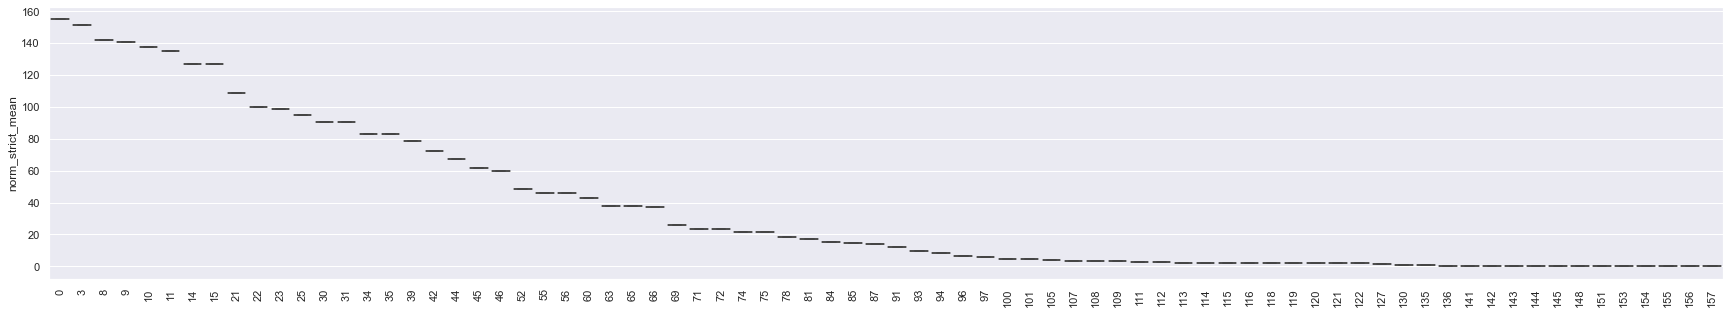

In [261]:
# Plotting plate 53
plate54 = sorted_df_lcms.loc[sorted_df_lcms['plate'] == 'yp54']

import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x=plate54.index, y='norm_strict_mean',data=plate54)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

## 1.10 Plotting plate 56 (53)

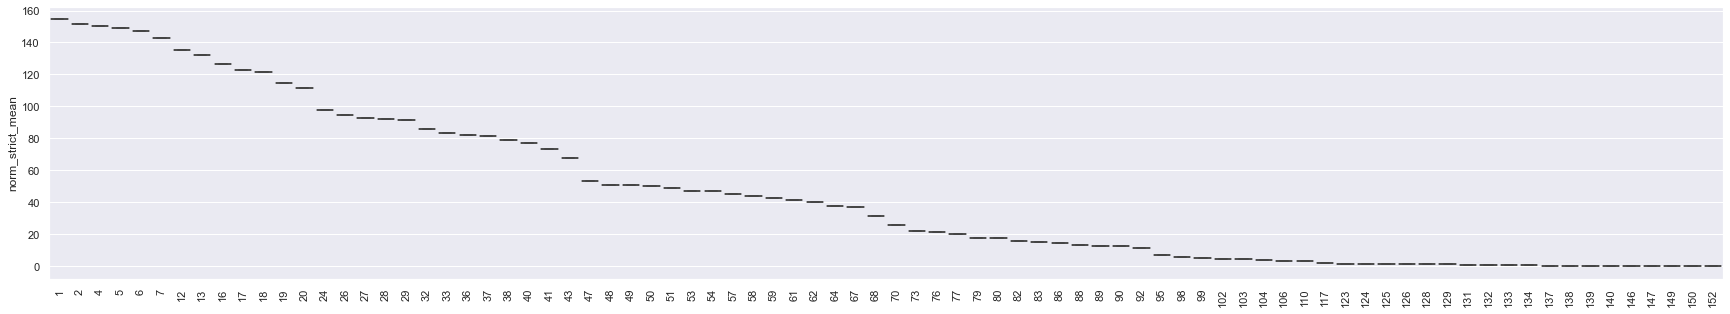

In [262]:
# Plotting plate 53
plate53 = sorted_df_lcms.loc[sorted_df_lcms['plate'] == 'yp53']

import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x=plate53.index, y='norm_strict_mean',data=plate53)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

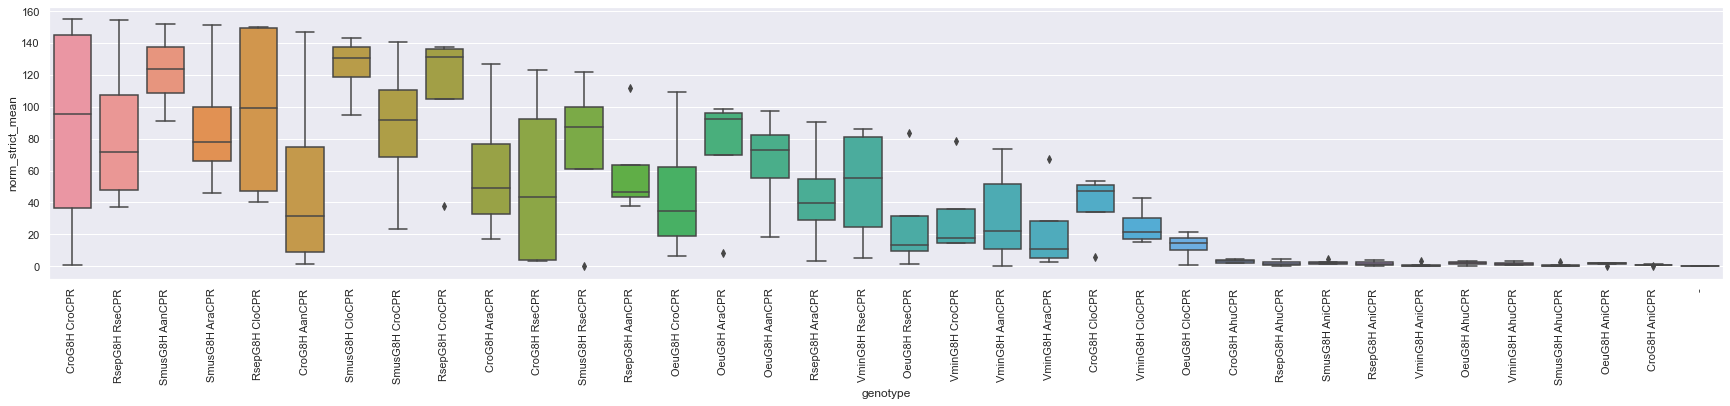

In [263]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(30,5)})


box_plot=sns.boxplot(x='genotype', y='norm_strict_mean',data=sorted_df_lcms)
oc, labels = plt.xticks()
box_plot.set_xticklabels(labels, rotation=90)
#makes sure we dont see the labels
None

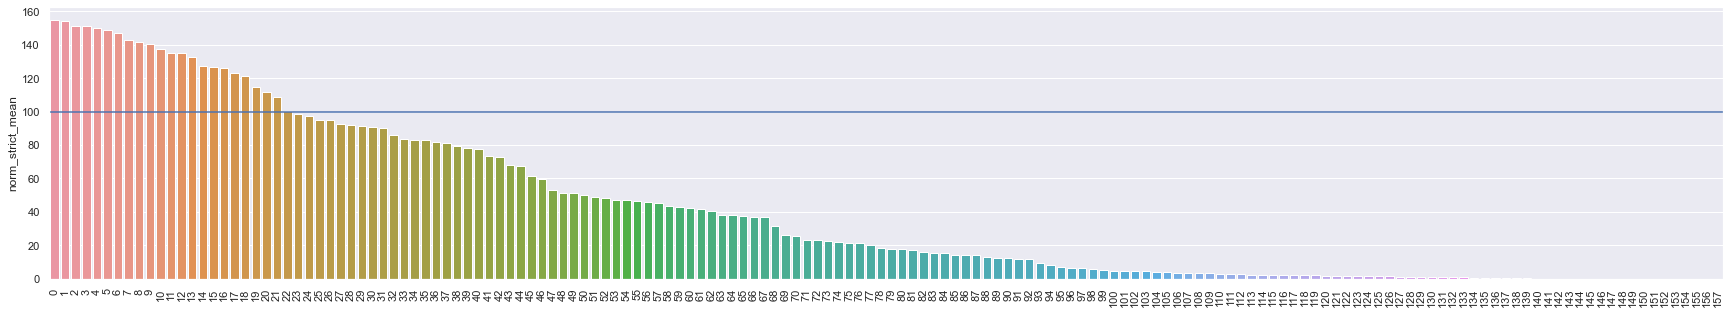

In [264]:
histogram = sns.barplot(data=sorted_df_lcms, x=sorted_df_lcms.index, y='norm_strict_mean')
histogram.axhline(100)

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)
# this makes sure the labels are not shown
None

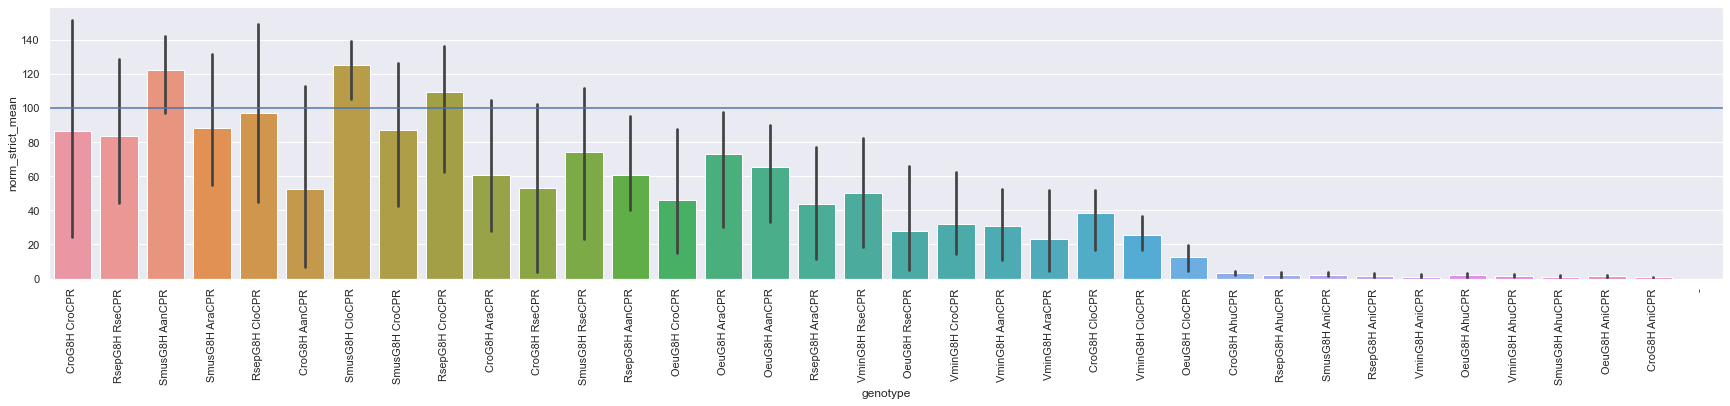

In [265]:
histogram = sns.barplot(data=sorted_df_lcms, x='genotype', y='norm_strict_mean')
histogram.axhline(100)

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)
# this makes sure the labels are not shown
None

# 2. Genotyping

Purpose: Determine promoters from library strains to enable ML based sampling of library space

Methods:
DNA sequencing of assembled clusters. Genomic DNA was extracted from
overnight cultures using the LiOAc/SDS method adapted to a 96-well microtiter
plate format. Each extract was used as a template in 2 PCR reactions spanning
the 2 integrated promoter gene pairs and amplifying from 2500 to 3200 bp. The PCR
products were validated using gel electrophoresis and sequenced
using PlateSeq PCR Kits (Eurofins) according to the manufacturer’s instructions.

From the gel results, a PCR reaction was considered as trusted if it showed a
strong band of the correct size; not trusted if it showed a strong band of the wrong
size, and as no information (NI) gained if it showed a weak or no band. 

From the
sequencing results, a sequencing reaction was considered as trusted if it showed an
unambiguous sequence of the expected length (i.e., only limited by length of PCR
fragment, stretches of the same nucleotide in the promoter or of ~1 kb limit of
sanger sequencing reactions), not trusted if it showed an unambiguous sequence of
the expected length with an assembly error, and NI gained if there were no or bad
sequence results. If one or more sequencing results from the same strain showed
double peaks in the promoter region the strain was considered as a double
population. 

Finally, the promoter was noted as a failed assembly if either gel
and or sequencing results were considered not trusted, as NI if the sequencing
result was NI and else as the promoter predicted by pairwise alignment between
sequencing results and promoter sequence.

## 2.1 Sequencing

### Submission


Eurofins     | SDP_ID | cassette
------------ | ------ | --------
PCR_00020748 | yp53   | g8h
PCR_00020750 | yp54   | g8h
PCR_00020747 | yp53   | cpr
PCR_00020749 | yp54   | cpr

In plateseq kits well h12 is reserved for quality control.
In all 6 plates yp49-51 for g8h & cpr well h12 contains medium control which do not need to be sequenced. Thus no need to rearrange samples.



In [266]:
import os

In [280]:
path = 'ConStrain_on_google_colab/Data/raw/10_Sanger_results/'
files = os.listdir(path)
files

['ab1_second_round',
 'PlateReport_yp51_cpr.xls',
 '.DS_Store',
 'Sanger',
 'PlateReport_yp49_cpr.xls',
 'PlateReport_yp50_cpr.xls',
 'PlateReport_yp51_g8h.xls',
 'PlateReport_yp54_cpr_Run1.xlsx',
 'ab1',
 'PlateReport_yp53_g8h_Run1.xlsx',
 'PlateReport_yp54_g8h_Run1.xlsx',
 'PlateReport_yp50_g8h.xls',
 'PlateReport_yp53_cpr_Run1.xlsx',
 'PlateReport_yp49_g8h.xls',
 '.ipynb_checkpoints',
 'sanger_fasta']

In [281]:
yp53_g8h = pd.read_excel('ConStrain_on_google_colab/Data/raw/10_Sanger_results/PlateReport_yp53_g8h_Run1.xlsx')
yp53_cpr = pd.read_excel('ConStrain_on_google_colab/Data/raw/10_Sanger_results/PlateReport_yp53_cpr_Run1.xlsx')
yp54_g8h = pd.read_excel('ConStrain_on_google_colab/Data/raw/10_Sanger_results/PlateReport_yp54_g8h_Run1.xlsx')
yp54_cpr = pd.read_excel('ConStrain_on_google_colab/Data/raw/10_Sanger_results/PlateReport_yp54_cpr_Run1.xlsx')


# list of all the dataframes
sequencing_plates = [yp53_g8h, yp53_cpr, yp54_g8h, yp54_cpr]

In [283]:
from constrain.lab.PCR import det_elon_time

In [284]:
from constrain.test.genotyping import plat_seq_data_wrangler, plate_AvgQual, split_df_names, concatenating_list_of_dfs, slicing_and_naming_seq_plates

### Data wrangling of plateSeq2 excel files

In [285]:
#Slicing plate data
sliced_plates = slicing_and_naming_seq_plates(sequencing_plates)

# Making the values numeric
list_of_dfs = plat_seq_data_wrangler(sliced_plates)

#filter them on their 
filtered_plates = plate_AvgQual(list_of_dfs)

# Split names
split_df = split_df_names(filtered_plates)

# concatenating the plates
all_data_frames = concatenating_list_of_dfs(split_df)

all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53re,A1
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53re,A2
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53re,A4
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53re,A6
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53re,A7
...,...,...,...,...,...,...,...,...,...
65,E11,yp54_cpr_E11,57.210332,1329.0,12.0,1095.0,1103.0,yp54,E11
66,E12,yp54_cpr_E12,56.280039,1161.0,23.0,1054.0,956.0,yp54,E12
70,F04,yp54_cpr_F4,55.799822,1280.0,22.0,1145.0,1136.0,yp54,F4
76,F10,yp54_cpr_F10,56.107972,1175.0,16.0,1006.0,960.0,yp54,F10


In [286]:
## Adding a zero to all the numers before 10
wells = []
plates = []
for index, row in all_data_frames.iterrows():
    if len(row['well']) == 2: 
        letter, number = row['well'][0:1], row['well'][1:2]
        #print(letter, number)
        row['well'] = letter + '0' + number
        wells.append(row['well'])
    else: 
        wells.append(row['well'])
        
    if row['plate'] == 'yp53re':
        plates.append('yp53')
        
    else:
        plates.append('yp54')
        
all_data_frames['well'] = wells
all_data_frames['plate'] = plates

all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53,A06
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53,A07
...,...,...,...,...,...,...,...,...,...
65,E11,yp54_cpr_E11,57.210332,1329.0,12.0,1095.0,1103.0,yp54,E11
66,E12,yp54_cpr_E12,56.280039,1161.0,23.0,1054.0,956.0,yp54,E12
70,F04,yp54_cpr_F4,55.799822,1280.0,22.0,1145.0,1136.0,yp54,F04
76,F10,yp54_cpr_F10,56.107972,1175.0,16.0,1006.0,960.0,yp54,F10


### ALL reads vs used bases 

In [287]:
concating_all_plates_with_bad_reads = concatenating_list_of_dfs(sequencing_plates)
# Making the values numeric
concating_all_plates_with_bad_reads["AvgQual"] = pd.to_numeric(concating_all_plates_with_bad_reads["AvgQual"])

concating_all_plates_with_bad_reads

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0
9,A03,yp53re_g8h_A3,0.000000,1337.0,0.0,0.0,21.0
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0
11,A05,yp53re_g8h_A5,49.158019,1026.0,22.0,445.0,347.0
...,...,...,...,...,...,...,...
81,G03,yp54_cpr_G3,0.000000,202.0,0.0,0.0,0.0
82,G04,H2O,0.000000,520.0,0.0,0.0,17.0
83,G05,Empty_2,0.000000,260.0,0.0,0.0,0.0
84,G06,Empty,0.000000,272.0,0.0,0.0,16.0


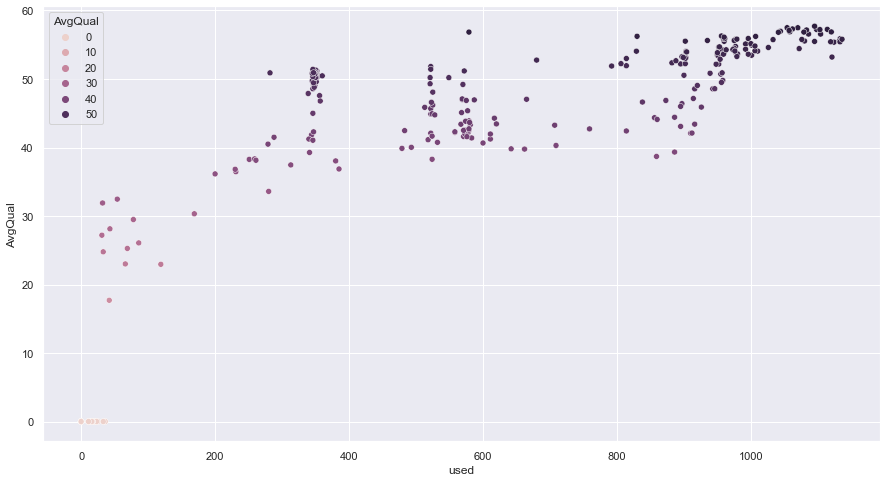

In [288]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(data=concating_all_plates_with_bad_reads, x="used", y="AvgQual", hue="AvgQual")
None

### AvgQual > 50 reads vs used bases 

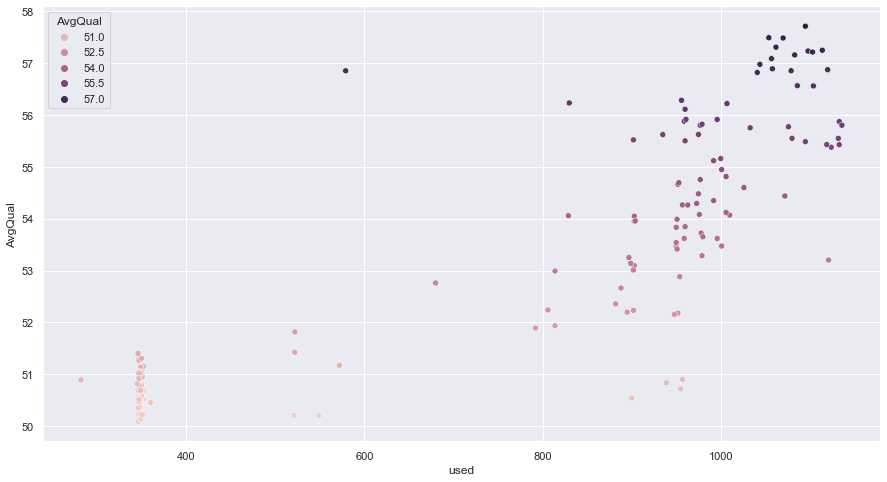

In [289]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(data=all_data_frames, x="used", y="AvgQual", hue="AvgQual")
#g = sns.scatterplot(x="AvgQual", y="used", data=concating_all_plates_with_bad_reads)
None

### Infering promoter to sample relationship

#### primers

In [290]:
from Bio import SeqIO

In [291]:
from constrain.lims.csv_database import get_dna_from_box_name
get_dna_from_box_name

<function constrain.lims.csv_database.get_dna_from_box_name(name: str, database_name: str, database_path='../data/csv_database/', genbank_files_path='../data/genbank_files/', genbank=False) -> Bio.SeqRecord.SeqRecord>

In [292]:
pad_pG8H_fw = get_dna_from_box_name('pad_pG8H_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')
pad_pCPR_fw = get_dna_from_box_name('pad_pCPR_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')

In [293]:
primers_for_seq = [pad_pG8H_fw, pad_pCPR_fw]
primers_for_seq

[SeqRecord(seq=Seq('TGCCCATTCGATAAGGCA'), id='10148.0', name='pad_pG8H_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCGTATGGACCTGTCT'), id='10144.0', name='pad_pCPR_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[])]

#### promoter

In [294]:
pG8H_template_names = ['pCYC1','pENO2']
pCPR_template_names = ['pCCW12','pTPI1']

In [295]:
path = 'ConStrain_on_google_colab/Data/csv_database/'
genbank_path = 'ConStrain_on_google_colab/Data/genbank_files/'

pG8H =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path,genbank = True, genbank_files_path = genbank_path) for name in pG8H_template_names]  
pCPR =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path, genbank = True, genbank_files_path = genbank_path) for name in pCPR_template_names]  

In [296]:
templates = pCPR+pG8H

In [297]:
pG8H

[SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description='', dbxrefs=[])]

In [298]:
path = '../data/raw/10_Sanger_results/ab1_second_round'
files = os.listdir(path)

In [299]:

reads = []
for read in files:
    if read != '.ipynb_checkpoints': 
        reads.append(SeqIO.read('../data/raw/10_Sanger_results/ab1_second_round/'+read, 'abi'))#
print(len(reads))

314


In [300]:
reads

[SeqRecord(seq=Seq('NNNNNNNNNGNNNGNNNNTTGGNNNNTTTCCAAAANTCAATAGCATGCAGGACG...NNN'), id='SEQ10004595_A2_C05_0', name='yp54_cpr_C5_C05-pad_cpr_fw', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNGNNTANTTTCCAAAAAANCAATAGCNTGC...NNN'), id='SEQ10004595_A1_D01_0', name='yp53re_cpr_D1_D01-pad_cpr_fw', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('NNNNNNNNNNNNNTCGNNNNNNNNNNGTTTTAGTGNGTGAATGAAATAGGTGTA...NNN'), id='SEQ10004595_B2_D01_0', name='yp54_g8h_D1_D01-pad_g8h_fw', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('NNNNNNNNNNNTTCGNNNNNNNNTGTTTTAGTGTGTGAATGAAATAGGTGTATG...NNA'), id='SEQ10004595_B1_C05_0', name='yp53re_g8h_C5_C05-pad_g8h_fw', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('NNNNNNNANNNNNNNNNTGANNGGCTACCAAAAACGATAATCTCAACTGTAAAC...NNN'), id='SEQ10004595_A2_A02_0', name='yp54_cpr_A2_A02-pad_cpr_fw', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('NNNNNNNNNNNNNCCAAATGAGCTAGAAGGTGGNNTTAACAAATATAATGACAA...NNN'), id='SEQ10004595_B2_C10_0', name='yp54

getting the hits that have a proper quality:
    

### Manual ab1 and promoter check 

### Detailed check of assemblies
- Manuel filtering. trusted / not_trusted ab1. 
- For certains strains multiple ab1 sequences get ambiguous only in promoters -> double population
- ab1 sequences quality drops preliminary due to stretches of same nucleotides in certain promoters  -> trusted even though small seq alignment 
- Low quality ab1 -> not_trusted


In [308]:
manual_checked = pd.read_excel('ConStrain_on_google_colab/Data/Sanger_seq_files/sequence_check_2nd_iteration.xlsx')
manual_checked.head(10)

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,Keep,Comment,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,yp53re,A01,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yp53re,A01,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yp53re,A02,2,5.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yp53re,A02,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yp53re,A03,2,NaN,no_information,no_information,no_information,small band,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,yp53re,A03,1,NaN,no_information,no_information,no_information,no_information,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,yp53re,A04,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,yp53re,A04,1,2.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,yp53re,A05,2,5.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,yp53re,A05,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets parse through the file and add the sequences to the all_sequences dataframe 

In [309]:
df_filterd_keep = manual_checked[manual_checked['Keep'] == True]

In [310]:
# making Sample-name from the information above
#yp49_cpr_A1_pad_cpr_fw	

sample_names = []
for index, row in df_filterd_keep.iterrows():
    if row['position'] == 1:
        name = 'g8h'
    if row['position'] == 2:
        name = 'cpr'
    
    # Getting the right nomeclature
    if row['well'][1] == '0': 
        well = row['well'][0]+row['well'][2]  
    else: 
        well = row['well']
    
    #'yp53re_g8h_F1_F01-pad_g8h_fw'
    sample_name = f"{row['plate']}_{name}_{well}_{well[0]}0{well[1]}-pad_{name}_fw" #sample_name = f"{row['plate']}_{name}_{well}_pad_{name}_fw"
    
    sample_names.append(sample_name)
    
df_filterd_keep['Sample-Name'] = sample_names


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1207/1319420344.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Sample-Name'] = sample_names


In [311]:
df_filterd_keep

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,Keep,Comment,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Sample-Name
0,yp53re,A01,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A1_A01-pad_cpr_fw
1,yp53re,A01,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_g8h_A1_A01-pad_g8h_fw
2,yp53re,A02,2,5.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A2_A02-pad_cpr_fw
3,yp53re,A02,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_g8h_A2_A02-pad_g8h_fw
6,yp53re,A04,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A4_A04-pad_cpr_fw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,yp54,F08,1,1.0,good,good,NaN,weak,True,2,NaN,NaN,NaN,NaN,NaN,NaN,yp54_g8h_F8_F08-pad_g8h_fw
300,yp54,F10,2,6.0,good,good,NaN,good,True,3,NaN,NaN,NaN,NaN,NaN,NaN,yp54_cpr_F10_F01-pad_cpr_fw
301,yp54,F10,1,1.0,good,good,NaN,good,True,3,NaN,NaN,NaN,NaN,NaN,NaN,yp54_g8h_F10_F01-pad_g8h_fw
302,yp54,F11,2,6.0,good,good,NaN,good,True,3,NaN,NaN,NaN,NaN,NaN,NaN,yp54_cpr_F11_F01-pad_cpr_fw


In [312]:
# Sample-Name	inf_part_name	align_score	inf_part_number
df_filterd_keep = df_filterd_keep[['Sample-Name', 'inf_promoter']]
df_filterd_keep.columns = ['Sample-Name', 'inf_part_number']
df_filterd_keep

,Sample-Name,inf_part_number
0,yp53re_cpr_A1_A01-pad_cpr_fw,5.0
1,yp53re_g8h_A1_A01-pad_g8h_fw,1.0
2,yp53re_cpr_A2_A02-pad_cpr_fw,5.0
3,yp53re_g8h_A2_A02-pad_g8h_fw,1.0
6,yp53re_cpr_A4_A04-pad_cpr_fw,5.0
...,...,...
297,yp54_g8h_F8_F08-pad_g8h_fw,1.0
300,yp54_cpr_F10_F01-pad_cpr_fw,6.0
301,yp54_g8h_F10_F01-pad_g8h_fw,1.0
302,yp54_cpr_F11_F01-pad_cpr_fw,6.0


## 2.2 Aligning promoters to reads - infer promoter alignment

In [313]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
numbers_list = [1, 2, 3, 4, 5, 6, 7, 8]

In [314]:
dict_of_promoters_and_numbers = {list_of_promoters[i]: numbers_list[i] for i in range(len(list_of_promoters))}
dict_of_promoters_and_numbers

{'pCYC1': 1,
 'pENO2': 2,
 'pPCK1': 3,
 'pRPL15B': 4,
 'pCCW12': 5,
 'pTPI1': 6,
 'pMLS1': 7,
 'pURE2': 8}

In [315]:
for i in range(len(templates)): 
    templates[i].description = dict_of_promoters_and_numbers[templates[i].name]
       
templates

[SeqRecord(seq=Seq('AAAGAAACTTAATACGTTATGCCGTAATGAAGGGCTACCAAAAACGATAATCTC...ATA'), id='10037', name='pCCW12', description=5, dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='10039', name='pTPI1', description=6, dbxrefs=[]),
 SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description=1, dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description=2, dbxrefs=[])]

### Tidying up data  

Since the library only was made with four promoters we will fetch those out so we dont have to align with the rest



In [316]:
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53,A06
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53,A07
...,...,...,...,...,...,...,...,...,...
65,E11,yp54_cpr_E11,57.210332,1329.0,12.0,1095.0,1103.0,yp54,E11
66,E12,yp54_cpr_E12,56.280039,1161.0,23.0,1054.0,956.0,yp54,E12
70,F04,yp54_cpr_F4,55.799822,1280.0,22.0,1145.0,1136.0,yp54,F04
76,F10,yp54_cpr_F10,56.107972,1175.0,16.0,1006.0,960.0,yp54,F10


In [320]:
# lets limit the alingment to only reads that are of proper quality
# all_data_frames
sample_names = df_filterd_keep['Sample-Name'].tolist()
print(len(sample_names))

good_samples = []
for i in range(len(reads)):
    for j in range(len(sample_names)): 
        if reads[i].name == sample_names[j]: 
            good_samples.append(reads[i])
            
            
len(good_samples)

279


210

## 2.3 Aligning with the pairwise_alignment_of_templates function

In [323]:
from constrain.test.genotyping import pairwise_alignment_of_templates

In [324]:
%%time
df_alignment = pairwise_alignment_of_templates(reads,templates, primers_for_seq)

df_alignment

CPU times: user 4min 46s, sys: 924 ms, total: 4min 47s
Wall time: 4min 47s


,Sample-Name,inf_part_name,align_score,inf_part_number
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5
...,...,...,...,...
309,yp53re_g8h_B9_B09-pad_g8h_fw,pENO2,959.0,2
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5
311,yp54_cpr_B9_B09-pad_cpr_fw,pTPI1,968.0,6
312,yp53re_g8h_A6_A06-pad_g8h_fw,pCYC1,520.0,1


In [411]:
col_list =  list(df_alignment["align_score"])
print(col_list)

[966.0, 925.0, 530.0, 502.0, 799.0, 964.0, 886.0, 944.0, 512.0, 868.0, 507.0, 882.0, 504.0, 963.0, 611.0, 959.0, 512.0, 790.0, 964.0, 906.0, 957.0, 952.0, 954.0, 930.0, 968.0, 717.0, 965.0, 521.0, 964.0, 498.0, 643.0, 942.0, 201.0, 511.0, 509.0, 959.0, 644.0, 811.0, 519.0, 512.0, 636.0, 766.0, 493.0, 512.0, 856.0, 969.0, 521.0, 965.0, 516.0, 663.0, 968.0, 944.0, 963.0, 857.0, 954.0, 798.0, 956.0, 964.0, 532.0, 874.0, 789.0, 509.0, 504.0, 484.0, 527.0, 662.0, 523.0, 648.0, 515.0, 945.0, 965.0, 810.0, 522.0, 529.0, 885.0, 684.0, 896.0, 972.0, 957.0, 964.0, 504.0, 828.0, 528.0, 488.0, 107.0, 957.0, 700.0, 961.0, 820.0, 523.0, 543.0, 780.0, 958.0, 521.0, 528.0, 926.0, 967.0, 967.0, 967.0, 957.0, 627.0, 681.0, 963.0, 518.0, 953.0, 464.0, 955.0, 519.0, 605.0, 398.0, 691.0, 963.0, 482.0, 529.0, 313.0, 790.0, 504.0, 688.0, 967.0, 505.0, 873.0, 954.0, 518.0, 247.0, 782.0, 584.0, 955.0, 951.0, 970.0, 634.0, 637.0, 599.0, 524.0, 509.0, 513.0, 945.0, 515.0, 493.0, 969.0, 521.0, 777.0, 954.0, 873.0

In [412]:
minvalue = df_alignment['align_score'].min()
minvalue

28.0

In [413]:
df_align_sort = df_alignment.sort_values(['Sample-Name'])
df_align_sort

,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
132,yp53re_cpr_A10_A10-pad_cpr_fw,pCCW12,634.0,5,2,yp53,A10
188,yp53re_cpr_A11_A11-pad_cpr_fw,pTPI1,904.0,6,2,yp53,A11
247,yp53re_cpr_A12_A12-pad_cpr_fw,pTPI1,851.0,6,2,yp53,A12
93,yp53re_cpr_A1_A01-pad_cpr_fw,pCCW12,543.0,5,2,yp53,A01
41,yp53re_cpr_A2_A02-pad_cpr_fw,pCCW12,636.0,5,2,yp53,A02
...,...,...,...,...,...,...,...
238,yp54_g8h_F9_F09-pad_g8h_fw,pCYC1,584.0,1,1,yp54,F09
241,yp54_g8h_G1_G01-pad_g8h_fw,pENO2,446.0,2,1,yp54,G01
217,yp54_g8h_G2_G02-pad_g8h_fw,pENO2,484.0,2,1,yp54,G02
117,yp54_g8h_G3_G03-pad_g8h_fw,pENO2,313.0,2,1,yp54,G03


#### Check with manual curation

In [423]:
df_align_sort_by_pairwise_alignment = df_align_sort[['Sample-Name','inf_part_number' ]]

# Merge and calculate diff - if more than 0 there is a desciptcency
df_align_sort_by_pairwise_alignment_MERGED = pd.merge(df_align_sort_by_pairwise_alignment, df_filterd_keep, on=['Sample-Name'])
df_align_sort_by_pairwise_alignment_MERGED['diff'] = df_align_sort_by_pairwise_alignment_MERGED['inf_part_number_x'] - df_align_sort_by_pairwise_alignment_MERGED['inf_part_number_y']

df_align_diff = df_align_sort_by_pairwise_alignment_MERGED.loc[df_align_sort_by_pairwise_alignment_MERGED['diff'] != 0]


df_align_diff

,Sample-Name,inf_part_number_x,inf_part_number_y,diff


In [424]:
df_alignment['position'] = ''
position = []
plate_list = []
well_list = []

for index, row in df_alignment.iterrows():
    # Split data
    
    split = str(row['Sample-Name'].split("_")[1])
    plate = str(row['Sample-Name'].split("_")[0])
    well = str(row['Sample-Name'].split("_")[3])
    
    # get the right position 
    if split == 'g8h': 
        position.append(1)
    if split == 'cpr': 
        position.append(2)
    plate_list.append(plate[0:4])
    well_list.append(well[0:3])
    
    
df_alignment['position'] = position
df_alignment['plate'] = plate_list
df_alignment['well'] = well_list
print('Duplicated samples:', df_alignment.duplicated(subset=['Sample-Name']).sum())

df_alignment

Duplicated samples: 0


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1207/1824287060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alignment['position'] = ''
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1207/1824287060.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alignment['position'] = position
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1207/1824287060.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1,1,yp54,D01
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1,1,yp53,C05
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
...,...,...,...,...,...,...,...
309,yp53re_g8h_B9_B09-pad_g8h_fw,pENO2,959.0,2,1,yp53,B09
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5,2,yp54,A06
311,yp54_cpr_B9_B09-pad_cpr_fw,pTPI1,968.0,6,2,yp54,B09
312,yp53re_g8h_A6_A06-pad_g8h_fw,pCYC1,520.0,1,1,yp53,A06


In [425]:
df_alignment = df_alignment.drop_duplicates(subset = ['Sample-Name'])
print('Duplicated samples:', df_alignment.duplicated(subset=['Sample-Name']).sum())


Duplicated samples: 0


grouping the positions

In [426]:
grouped = df_alignment.groupby(df_alignment.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)
print('Duplicated samples:', g8h_df.duplicated(subset=['Sample-Name']).sum())
cpr_df

Duplicated samples: 0


,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
6,yp53re_cpr_F6_F06-pad_cpr_fw,pTPI1,886.0,6,2,yp53,F06
9,yp53re_cpr_E9_E09-pad_cpr_fw,pTPI1,868.0,6,2,yp53,E09
...,...,...,...,...,...,...,...
304,yp54_cpr_C1_C01-pad_cpr_fw,pTPI1,960.0,6,2,yp54,C01
307,yp54_cpr_F12_F12-pad_cpr_fw,pTPI1,584.0,6,2,yp54,F12
308,yp53re_cpr_F2_F02-pad_cpr_fw,pCCW12,711.0,5,2,yp53,F02
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5,2,yp54,A06


In [427]:
minvalue = cpr_df['align_score'].min()
minvalue

28.0

In [428]:
print('Duplicated samples:', cpr_df.duplicated(subset=['Sample-Name']).sum())


Duplicated samples: 0


In [429]:
cpr_df

,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
6,yp53re_cpr_F6_F06-pad_cpr_fw,pTPI1,886.0,6,2,yp53,F06
9,yp53re_cpr_E9_E09-pad_cpr_fw,pTPI1,868.0,6,2,yp53,E09
...,...,...,...,...,...,...,...
304,yp54_cpr_C1_C01-pad_cpr_fw,pTPI1,960.0,6,2,yp54,C01
307,yp54_cpr_F12_F12-pad_cpr_fw,pTPI1,584.0,6,2,yp54,F12
308,yp53re_cpr_F2_F02-pad_cpr_fw,pCCW12,711.0,5,2,yp53,F02
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5,2,yp54,A06


In [430]:
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53,A06
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53,A07
...,...,...,...,...,...,...,...,...,...
65,E11,yp54_cpr_E11,57.210332,1329.0,12.0,1095.0,1103.0,yp54,E11
66,E12,yp54_cpr_E12,56.280039,1161.0,23.0,1054.0,956.0,yp54,E12
70,F04,yp54_cpr_F4,55.799822,1280.0,22.0,1145.0,1136.0,yp54,F04
76,F10,yp54_cpr_F10,56.107972,1175.0,16.0,1006.0,960.0,yp54,F10


In [431]:
all_data_frames.duplicated(subset=['Sample-Name']).sum()

0

In [432]:
# lets merge the quality dataframe
infered_promoters_df = pd.merge(all_data_frames, df_alignment, on=['plate', 'well'])

In [433]:
infered_promoters_df

,Number,Sample-Name_x,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well,Sample-Name_y,inf_part_name,align_score,inf_part_number,position
0,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01,yp53re_cpr_A1_A01-pad_cpr_fw,pCCW12,543.0,5,2
1,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01,yp53re_g8h_A1_A01-pad_g8h_fw,pCYC1,518.0,1,1
2,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02,yp53re_g8h_A2_A02-pad_g8h_fw,pCYC1,507.0,1,1
3,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02,yp53re_cpr_A2_A02-pad_cpr_fw,pCCW12,636.0,5,2
4,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04,yp53re_g8h_A4_A04-pad_g8h_fw,pENO2,957.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,C09,yp54_cpr_C9,56.869328,1314.0,24.0,1125.0,1120.0,yp54,C09,yp54_cpr_C9_C09-pad_cpr_fw,pTPI1,971.0,6,2
335,D12,yp54_cpr_D12,57.229767,1271.0,23.0,1097.0,1098.0,yp54,D12,yp54_cpr_D12_D12-pad_cpr_fw,pTPI1,967.0,6,2
336,D12,yp54_cpr_D12,57.229767,1271.0,23.0,1097.0,1098.0,yp54,D12,yp54_g8h_D12_D12-pad_g8h_fw,pCYC1,521.0,1,1
337,E04,yp54_cpr_E4,50.200389,1132.0,84.0,597.0,549.0,yp54,E04,yp54_cpr_E4_E04-pad_cpr_fw,pCCW12,700.0,5,2


In [434]:
infered_promoters_df = infered_promoters_df[["plate", "well", "inf_part_number", "position"]]
infered_promoters_df

,plate,well,inf_part_number,position
0,yp53,A01,5,2
1,yp53,A01,1,1
2,yp53,A02,1,1
3,yp53,A02,5,2
4,yp53,A04,2,1
...,...,...,...,...
334,yp54,C09,6,2
335,yp54,D12,6,2
336,yp54,D12,1,1
337,yp54,E04,5,2


In [435]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, on=['plate','well' ])
promoter_to_well

,plate,well,inf_promoter1,inf_promoter2
0,yp53,A01,1,5
1,yp53,A02,1,5
2,yp53,A04,2,5
3,yp53,A06,1,5
4,yp53,A07,2,6
...,...,...,...,...
230,yp54,A04,1,6
231,yp54,C04,2,6
232,yp54,C09,1,6
233,yp54,D12,1,6


In [436]:
print(promoter_to_well.duplicated(subset=['plate', 'well']).sum())


102


In [437]:
promoter_to_well.head(50)

,plate,well,inf_promoter1,inf_promoter2
0,yp53,A01,1,5
1,yp53,A02,1,5
2,yp53,A04,2,5
3,yp53,A06,1,5
4,yp53,A07,2,6
5,yp53,A08,1,6
6,yp53,A09,1,6
7,yp53,A10,2,5
8,yp53,A11,1,6
9,yp53,A12,1,6


In [438]:
print(len(g8h_df))
print(len(cpr_df))

170
169


In [439]:
df_alignment['inf_part_number'] = df_alignment['inf_part_number'].astype('int')

Sanity check - did we get the correct promoters in each well? 


In [440]:
bad_indexes = []

for index, row in df_alignment.iterrows():
    if row['position'] == 1 and row['inf_part_number'] > 4:
        print('SOMTHING WRONG WITH G8H', row['align_score'], index)
        bad_indexes.append(index)
    if row['position'] == 2 and int(row['inf_part_number']) < 5:
        print('SOMTHING WRONG WITH CPR', row['align_score'])
        bad_indexes.append(index)
bad_indexes

[]

In [441]:
df_alignment.drop(bad_indexes, axis=0, inplace=True)

df_alignment

,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1,1,yp54,D01
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1,1,yp53,C05
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
...,...,...,...,...,...,...,...
309,yp53re_g8h_B9_B09-pad_g8h_fw,pENO2,959.0,2,1,yp53,B09
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5,2,yp54,A06
311,yp54_cpr_B9_B09-pad_cpr_fw,pTPI1,968.0,6,2,yp54,B09
312,yp53re_g8h_A6_A06-pad_g8h_fw,pCYC1,520.0,1,1,yp53,A06


# 3. Combine data


In [2]:
promoter_genotype_relationship = pd.merge(promoter_to_well, sorted_df_lcms, on=['plate','well' ])
len(promoter_genotype_relationship)

NameError: name 'pd' is not defined

In [3]:
promoter_genotype_relationship["genotype"]= promoter_genotype_relationship["genotype"].astype(str)

promoter_genotype_relationship = promoter_genotype_relationship.loc[promoter_genotype_relationship['genotype'] != 'nan']


NameError: name 'promoter_genotype_relationship' is not defined

In [444]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


g8h_genotype = []
cpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in promoter_genotype_relationship.iterrows():
    g8h_geno = str(row['genotype'].split(" ")[0])
    cpr_geno = str(row['genotype'].split(" ")[1])
    
    g8h_pos = g8h_list_of_index.index(str(row['genotype'].split(" ")[0]))+1
    cpr_pos = cpr_list_of_index.index(str(row['genotype'].split(" ")[1]))+1

    
    g8h_genotype.append(g8h_pos)
    cpr_genotype.append(cpr_pos)
    
promoter_genotype_relationship['G8H'] = g8h_genotype
promoter_genotype_relationship['CPR'] = cpr_genotype
    
print(len(promoter_genotype_relationship))
promoter_genotype_relationship

222


,plate,well,inf_promoter1,inf_promoter2,index,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,...,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean,strain,col_no,genotype,medium,G8H,CPR
0,yp53,A01,1,5,62,yp53_A01,yp53,A01,2.546823,yp55,...,2.000384,9.058562,5.196491,7.127526,MIA-HA-116,1.0,VminG8H AanCPR,YPD,4,2
1,yp53,A02,1,5,84,yp53_A02,yp53,A02,7.921696,yp55,...,6.361643,28.175952,16.525934,22.350943,MIA-HA-116,2.0,VminG8H AanCPR,YPD,4,2
2,yp53,A04,2,5,119,yp53_A04,yp53,A04,22.597750,yp55,...,25.466008,80.375862,66.154223,73.265043,MIA-HA-116,4.0,VminG8H AanCPR,YPD,4,2
3,yp53,A06,1,5,146,yp53_A06,yp53,A06,34.235068,yp55,...,41.272486,121.767572,107.215440,114.491506,MIA-HA-117,2.0,SmusG8H AanCPR,YPD,5,2
4,yp53,A07,2,6,165,yp53_A07,yp53,A07,44.719792,yp55,...,55.490800,159.059724,144.151010,151.605367,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,yp54,A04,1,6,70,yp54_A04,yp54,A04,4.326963,yp55,...,5.081901,15.322951,13.201487,14.262219,MIA-HA-111,4.0,VminG8H CroCPR,SC-UT,4,1
231,yp54,C04,2,6,125,yp54_C04,yp54,C04,26.634041,yp55,...,27.674967,94.318358,71.892536,83.105447,MIA-HA-122,4.0,SmusG8H AraCPR,SC-UT,5,3
232,yp54,C09,1,6,94,yp54_C09,yp54,C09,13.122270,yp55,...,11.424532,46.469517,29.678034,38.073775,MIA-HA-124,1.0,CroG8H AraCPR,SC-UT,3,3
233,yp54,D12,1,6,46,yp54_D12,yp54,D12,1.049920,yp56,...,0.648354,3.718051,1.356013,2.537032,MIA-HA-137,4.0,SmusG8H AhuCPR,SC-UT,5,6


make new dataframe of promoters: 


plate


In [445]:
promoter_genotype_relationship = promoter_genotype_relationship[['plate', 'well', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR',  'Amt_uM_Strictosidine_x','Amt_uM_Strictosidine_y','norm_strict_x', 'norm_strict_y',  'norm_strict_mean']]
promoter_genotype_relationship

,plate,well,G8H,inf_promoter1,inf_promoter2,CPR,Amt_uM_Strictosidine_x,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean
0,yp53,A01,4,1,5,2,2.546823,2.000384,9.058562,5.196491,7.127526
1,yp53,A02,4,1,5,2,7.921696,6.361643,28.175952,16.525934,22.350943
2,yp53,A04,4,2,5,2,22.597750,25.466008,80.375862,66.154223,73.265043
3,yp53,A06,5,1,5,2,34.235068,41.272486,121.767572,107.215440,114.491506
4,yp53,A07,5,2,6,2,44.719792,55.490800,159.059724,144.151010,151.605367
...,...,...,...,...,...,...,...,...,...,...,...
230,yp54,A04,4,1,6,1,4.326963,5.081901,15.322951,13.201487,14.262219
231,yp54,C04,5,2,6,3,26.634041,27.674967,94.318358,71.892536,83.105447
232,yp54,C09,3,1,6,3,13.122270,11.424532,46.469517,29.678034,38.073775
233,yp54,D12,5,1,6,6,1.049920,0.648354,3.718051,1.356013,2.537032


In [446]:
promoter_genotype_relationship['Line_name'] = promoter_genotype_relationship['plate'] + '_' + promoter_genotype_relationship['well']

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1207/1158976612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_genotype_relationship['Line_name'] = promoter_genotype_relationship['plate'] + '_' + promoter_genotype_relationship['well']


In [447]:
promoter_genotype_relationship = promoter_genotype_relationship.drop_duplicates()
promoter_genotype_relationship

,plate,well,G8H,inf_promoter1,inf_promoter2,CPR,Amt_uM_Strictosidine_x,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean,Line_name
0,yp53,A01,4,1,5,2,2.546823,2.000384,9.058562,5.196491,7.127526,yp53_A01
1,yp53,A02,4,1,5,2,7.921696,6.361643,28.175952,16.525934,22.350943,yp53_A02
2,yp53,A04,4,2,5,2,22.597750,25.466008,80.375862,66.154223,73.265043,yp53_A04
3,yp53,A06,5,1,5,2,34.235068,41.272486,121.767572,107.215440,114.491506,yp53_A06
4,yp53,A07,5,2,6,2,44.719792,55.490800,159.059724,144.151010,151.605367,yp53_A07
...,...,...,...,...,...,...,...,...,...,...,...,...
230,yp54,A04,4,1,6,1,4.326963,5.081901,15.322951,13.201487,14.262219,yp54_A04
231,yp54,C04,5,2,6,3,26.634041,27.674967,94.318358,71.892536,83.105447,yp54_C04
232,yp54,C09,3,1,6,3,13.122270,11.424532,46.469517,29.678034,38.073775,yp54_C09
233,yp54,D12,5,1,6,6,1.049920,0.648354,3.718051,1.356013,2.537032,yp54_D12


In [448]:
print(promoter_genotype_relationship.duplicated(subset = ['Line_name']).sum())
promoter_genotype_relationship_for_ml_ALL = promoter_genotype_relationship.drop_duplicates(subset='Line_name')

0


#### 3.1 - 1.st round normalized data

In [449]:
promoter_genotype_relationship_1st_analytics_round = promoter_genotype_relationship[['Line_name','plate', 'well', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR',  'Amt_uM_Strictosidine_x','norm_strict_x']]

promoter_genotype_relationship_1st_analytics_round.columns = ['Line_name','plate', 'well', '0','1', '2', '3',  'Amt_uM_Strictosidine', 'Amt_norm']
promoter_genotype_relationship_1st_analytics_round


,Line_name,plate,well,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,yp53,A01,4,1,5,2,2.546823,9.058562
1,yp53_A02,yp53,A02,4,1,5,2,7.921696,28.175952
2,yp53_A04,yp53,A04,4,2,5,2,22.597750,80.375862
3,yp53_A06,yp53,A06,5,1,5,2,34.235068,121.767572
4,yp53_A07,yp53,A07,5,2,6,2,44.719792,159.059724
...,...,...,...,...,...,...,...,...,...
230,yp54_A04,yp54,A04,4,1,6,1,4.326963,15.322951
231,yp54_C04,yp54,C04,5,2,6,3,26.634041,94.318358
232,yp54_C09,yp54,C09,3,1,6,3,13.122270,46.469517
233,yp54_D12,yp54,D12,5,1,6,6,1.049920,3.718051


#### 3.2 - 2nd round normalized data

In [450]:
promoter_genotype_relationship_2nd_analytics_round = promoter_genotype_relationship[['Line_name','plate', 'well', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR',  'Amt_uM_Strictosidine_y','norm_strict_y']]

promoter_genotype_relationship_2nd_analytics_round.columns = ['Line_name','plate', 'well', '0','1', '2', '3',  'Amt_uM_Strictosidine', 'Amt_norm']
promoter_genotype_relationship_2nd_analytics_round


,Line_name,plate,well,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,yp53,A01,4,1,5,2,2.000384,5.196491
1,yp53_A02,yp53,A02,4,1,5,2,6.361643,16.525934
2,yp53_A04,yp53,A04,4,2,5,2,25.466008,66.154223
3,yp53_A06,yp53,A06,5,1,5,2,41.272486,107.215440
4,yp53_A07,yp53,A07,5,2,6,2,55.490800,144.151010
...,...,...,...,...,...,...,...,...,...
230,yp54_A04,yp54,A04,4,1,6,1,5.081901,13.201487
231,yp54_C04,yp54,C04,5,2,6,3,27.674967,71.892536
232,yp54_C09,yp54,C09,3,1,6,3,11.424532,29.678034
233,yp54_D12,yp54,D12,5,1,6,6,0.648354,1.356013


#### 3.3 - Combined normalized data

In [1]:
promoter_genotype_relationship_1st_analytics_round = promoter_genotype_relationship[['Line_name','plate', 'well', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR','norm_strict_mean']]

promoter_genotype_relationship_1st_analytics_round.columns = ['Line_name','plate', 'well', '0','1', '2', '3',   'Amt_norm']
promoter_genotype_relationship_1st_analytics_round.sort_values(by='Amt_norm', ascending=False)


NameError: name 'promoter_genotype_relationship' is not defined

In [453]:
promoter_genotype_relationship.to_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_LL2.csv')

# 4. Plotting:

In [708]:
input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration_LL.csv', index_col= False)
input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,Amt_norm
0,0,yp53_A01,4,1,5,2,9.058562
1,1,yp53_A02,4,1,5,2,28.175952
2,2,yp53_A04,4,2,5,2,80.375862
3,3,yp53_A06,5,1,5,2,121.767572
4,4,yp53_A07,5,2,6,2,159.059724
...,...,...,...,...,...,...,...
124,232,yp54_A04,4,1,6,1,15.390179
125,233,yp54_C04,5,2,6,3,94.732175
126,234,yp54_C09,3,1,6,3,46.673399
127,235,yp54_D12,5,1,6,6,3.734364


### Stacked barplot

In [709]:
promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}
promoter_dict

{1: 'pCYC1',
 2: 'pENO2',
 3: 'pPCK1',
 4: 'pRPL15B',
 5: 'pCCW12',
 6: 'pTPI1',
 7: 'pMLS1',
 8: 'pURE2'}

In [710]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

    
    
    
input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype
    
len(promoter_genotype_relationship)

129

In [711]:
for_plotting_input_for_ml = input_for_ml[['Line_name', 'G8H', 'pG8H','pCPR', 'CPR','Amt_norm' ]]
for_plotting_input_for_ml

,Line_name,G8H,pG8H,pCPR,CPR,Amt_norm
0,yp53_A01,VminG8H,pCYC1,pCCW12,AanCPR,9.058562
1,yp53_A02,VminG8H,pCYC1,pCCW12,AanCPR,28.175952
2,yp53_A04,VminG8H,pENO2,pCCW12,AanCPR,80.375862
3,yp53_A06,SmusG8H,pCYC1,pCCW12,AanCPR,121.767572
4,yp53_A07,SmusG8H,pENO2,pTPI1,AanCPR,159.059724
...,...,...,...,...,...,...
124,yp54_A04,VminG8H,pCYC1,pTPI1,CroCPR,15.390179
125,yp54_C04,SmusG8H,pENO2,pTPI1,AraCPR,94.732175
126,yp54_C09,CroG8H,pCYC1,pTPI1,AraCPR,46.673399
127,yp54_D12,SmusG8H,pCYC1,pTPI1,AhuCPR,3.734364


In [712]:
simple_plotting = for_plotting_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']]
simple_plotting


,G8H,pG8H,pCPR,CPR
0,VminG8H,pCYC1,pCCW12,AanCPR
1,VminG8H,pCYC1,pCCW12,AanCPR
2,VminG8H,pENO2,pCCW12,AanCPR
3,SmusG8H,pCYC1,pCCW12,AanCPR
4,SmusG8H,pENO2,pTPI1,AanCPR
...,...,...,...,...
124,VminG8H,pCYC1,pTPI1,CroCPR
125,SmusG8H,pENO2,pTPI1,AraCPR
126,CroG8H,pCYC1,pTPI1,AraCPR
127,SmusG8H,pCYC1,pTPI1,AhuCPR


In [713]:
g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())

all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])
all_counts

,G8H,pG8H,pCPR,CPR
VminG8H,27.0,NaN,NaN,NaN
OeuG8H,27.0,NaN,NaN,NaN
RsepG8H,26.0,NaN,NaN,NaN
CroG8H,25.0,NaN,NaN,NaN
SmusG8H,24.0,NaN,NaN,NaN
pCYC1,NaN,71.0,NaN,NaN
pENO2,NaN,58.0,NaN,NaN
pTPI1,NaN,NaN,75.0,NaN
pCCW12,NaN,NaN,54.0,NaN
AanCPR,NaN,NaN,NaN,20.0


In [714]:
cpr_counts

,CPR
AanCPR,20
AniCPR,20
RseCPR,19
CroCPR,18
AhuCPR,18
CloCPR,17
AraCPR,17


In [715]:
g8h_counts = dict(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = dict(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = dict(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = dict(for_plotting_input_for_ml["CPR"].value_counts())

all_counts_as_list = [g8h_counts,pg8h_counts,pcpr_counts,cpr_counts]
all_counts_as_list

[{'VminG8H': 27, 'OeuG8H': 27, 'RsepG8H': 26, 'CroG8H': 25, 'SmusG8H': 24},
 {'pCYC1': 71, 'pENO2': 58},
 {'pTPI1': 75, 'pCCW12': 54},
 {'AanCPR': 20,
  'AniCPR': 20,
  'RseCPR': 19,
  'CroCPR': 18,
  'AhuCPR': 18,
  'CloCPR': 17,
  'AraCPR': 17}]

In [716]:
def counting_occurences(data_with_occurences:dict): 
    columns = []
    data = []
    for key,value in data_with_occurences.items(): 

        values = cpr_counts.values()
        total = sum(values)

        data.append(value/total)
        columns.append(key)
        
    return data, columns

In [717]:
# Occurences
names_list = ['G8H', 'pG8H', 'pCPR', 'CPR']

dataframes = []
for i in range(len(all_counts_as_list)): 
    data, columns = counting_occurences(all_counts_as_list[i])
    dataframes.append(pd.DataFrame(data, columns=[names_list[i]], index=columns))
    print(data, columns)

[0.20930232558139536, 0.20930232558139536, 0.20155038759689922, 0.1937984496124031, 0.18604651162790697] ['VminG8H', 'OeuG8H', 'RsepG8H', 'CroG8H', 'SmusG8H']
[0.5503875968992248, 0.4496124031007752] ['pCYC1', 'pENO2']
[0.5813953488372093, 0.4186046511627907] ['pTPI1', 'pCCW12']
[0.15503875968992248, 0.15503875968992248, 0.14728682170542637, 0.13953488372093023, 0.13953488372093023, 0.13178294573643412, 0.13178294573643412] ['AanCPR', 'AniCPR', 'RseCPR', 'CroCPR', 'AhuCPR', 'CloCPR', 'AraCPR']


In [718]:
all_df_for_stacked_plot = pd.concat(dataframes)
all_df_for_stacked_plot = all_df_for_stacked_plot.T
all_df_for_stacked_plot

,VminG8H,OeuG8H,RsepG8H,CroG8H,SmusG8H,pCYC1,pENO2,pTPI1,pCCW12,AanCPR,AniCPR,RseCPR,CroCPR,AhuCPR,CloCPR,AraCPR
G8H,0.209302,0.209302,0.20155,0.193798,0.186047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pG8H,NaN,NaN,NaN,NaN,NaN,0.550388,0.449612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pCPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581395,0.418605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155039,0.155039,0.147287,0.139535,0.139535,0.131783,0.131783


Text(0, 0.5, 'Percentage of occurence')

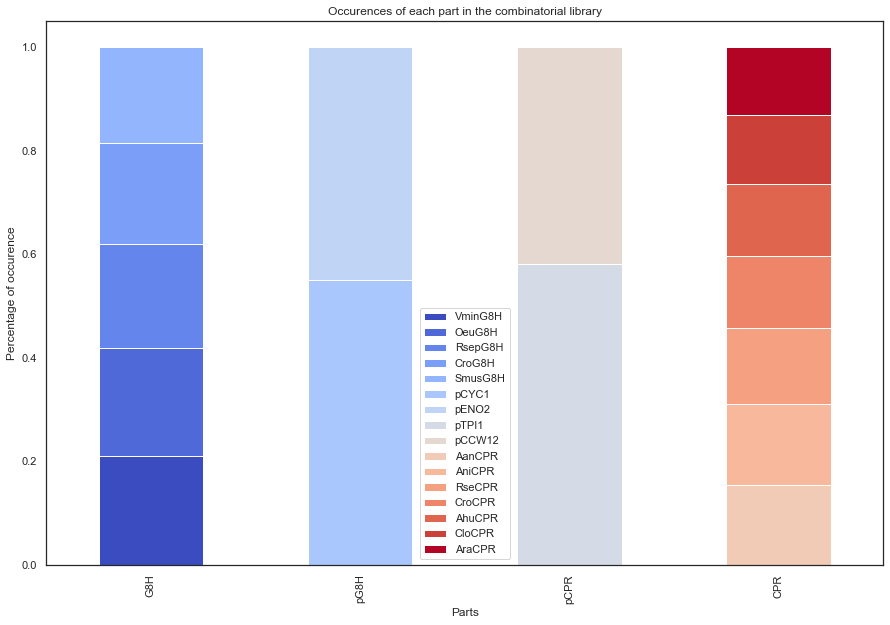

In [719]:
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='white')
sns.color_palette("icefire", as_cmap=True)


all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(15, 10), cmap="coolwarm")
# Add Title and Labels
plt.title('Occurences of each part in the combinatorial library')
plt.xlabel('Parts')
plt.ylabel('Percentage of occurence')

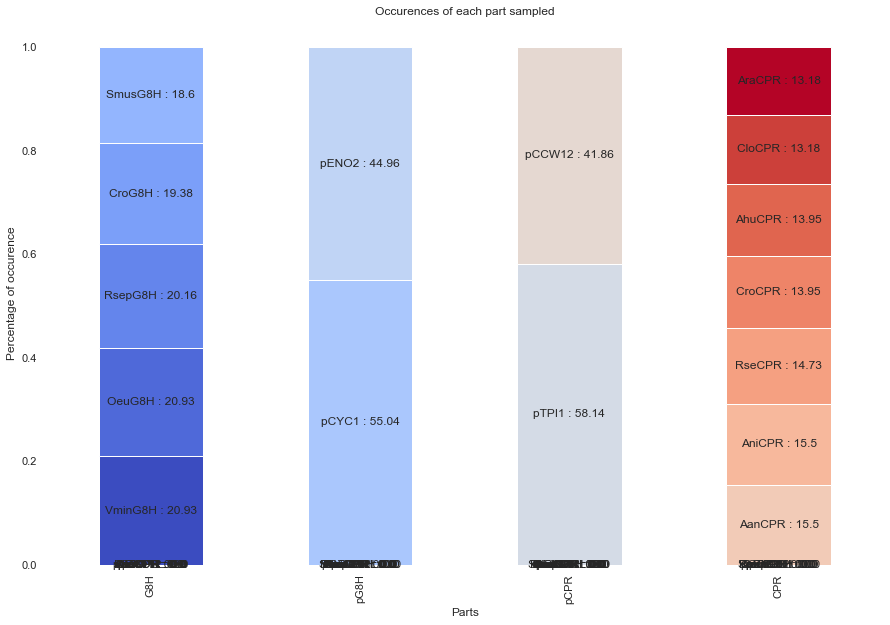

In [720]:
import seaborn as sns
sns.set_theme( style='white')


ax = all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(15, 10), cmap="coolwarm") # , cmap="coolwarm"
# Add Title and Labels
plt.title('Occurences of each part sampled')
plt.xlabel('Parts')
plt.ylabel('Percentage of occurence')


# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend([],[],frameon=False) # around the legend


# adding laves to each box
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    #labels = [round(v.get_height()*100,2)  if v.get_height() > 0 else '' for v in c]
    
    # this one writes label and percent 
    labels = [f"{c.get_label()} : {round(v.get_height()*100,2)}"  for v in c]

    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


### Bar plots

In [721]:
second_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration.csv')
second_round_top_producers = second_round_top_producers.sort_values(by='Amt_norm', ascending=False)

In [722]:
second_round_top_producers.sort_values(by='Amt_norm', ascending=False)

,Line Name,0,1,2,3,Amt_norm
43,yp53_D09,5,2,6,5,169.631396
28,yp53_C06,6,2,6,4,159.517718
5,yp53_A07,5,2,6,2,159.059724
48,yp53_E02,6,2,6,5,145.152656
12,yp53_B02,3,2,6,2,144.982414
...,...,...,...,...,...,...
62,yp53_F04,4,1,5,7,0.000000
121,yp54_E12,7,1,6,6,0.000000
69,yp53_F12,6,1,6,7,0.000000
70,yp53_G01,3,1,6,7,0.000000


In [723]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_round_top_producers.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_round_top_producers['G8H'] = g8h_genotype
second_round_top_producers['CPR'] = cpr_genotype
second_round_top_producers['pG8H'] = pg8h_genotype
second_round_top_producers['pCPR'] = pcpr_genotype

In [724]:
second_round_top_producers = second_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','Amt_norm' ]]
second_round_top_producers

,G8H,pG8H,pCPR,CPR,Amt_norm
43,SmusG8H,pENO2,pTPI1,RseCPR,169.631396
28,RsepG8H,pENO2,pTPI1,CloCPR,159.517718
5,SmusG8H,pENO2,pTPI1,AanCPR,159.059724
48,RsepG8H,pENO2,pTPI1,RseCPR,145.152656
12,CroG8H,pENO2,pTPI1,AanCPR,144.982414
...,...,...,...,...,...
62,VminG8H,pCYC1,pCCW12,AniCPR,0.000000
121,OeuG8H,pCYC1,pTPI1,AhuCPR,0.000000
69,RsepG8H,pCYC1,pTPI1,AniCPR,0.000000
70,CroG8H,pCYC1,pTPI1,AniCPR,0.000000


In [725]:
# Using DataFrame.agg() to combine two columns of text
second_round_top_producers["Names"] = second_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_round_top_producers= second_round_top_producers.reset_index()

second_round_top_producers_TOP20 = second_round_top_producers[:20]
second_round_top_producers_TOP20

,index,G8H,pG8H,pCPR,CPR,Amt_norm,Names
0,43,SmusG8H,pENO2,pTPI1,RseCPR,169.631396,SmusG8H-pENO2-pTPI1-RseCPR
1,28,RsepG8H,pENO2,pTPI1,CloCPR,159.517718,RsepG8H-pENO2-pTPI1-CloCPR
2,5,SmusG8H,pENO2,pTPI1,AanCPR,159.059724,SmusG8H-pENO2-pTPI1-AanCPR
3,48,RsepG8H,pENO2,pTPI1,RseCPR,145.152656,RsepG8H-pENO2-pTPI1-RseCPR
4,12,CroG8H,pENO2,pTPI1,AanCPR,144.982414,CroG8H-pENO2-pTPI1-AanCPR
5,23,SmusG8H,pCYC1,pCCW12,CloCPR,143.483630,SmusG8H-pCYC1-pCCW12-CloCPR
6,26,SmusG8H,pCYC1,pCCW12,CloCPR,140.086994,SmusG8H-pCYC1-pCCW12-CloCPR
7,84,CroG8H,pENO2,pTPI1,CroCPR,138.267757,CroG8H-pENO2-pTPI1-CroCPR
8,51,CroG8H,pENO2,pCCW12,RseCPR,132.656867,CroG8H-pENO2-pCCW12-RseCPR
9,8,RsepG8H,pENO2,pCCW12,AanCPR,129.715993,RsepG8H-pENO2-pCCW12-AanCPR


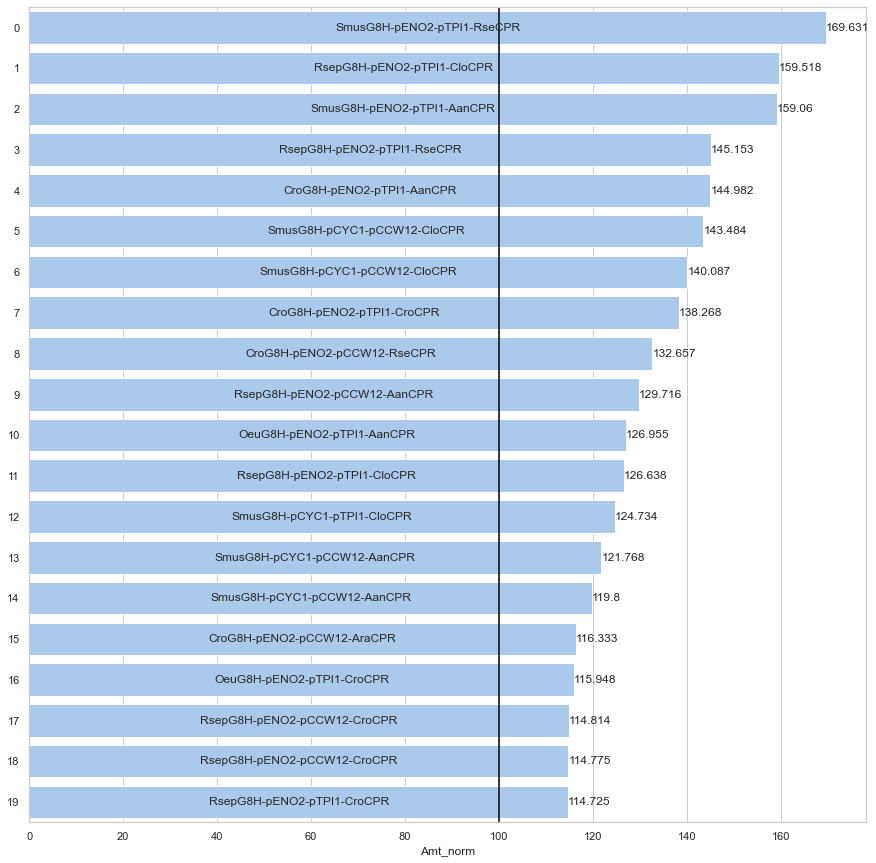

In [726]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# Font size
#sns.set_context("paper", rc={"font.size":8})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))


# Initializing plot
sns.set_color_codes('pastel')
ax = sns.barplot(x = 'Amt_norm', y = [i for i in second_round_top_producers_TOP20.index], data = second_round_top_producers_TOP20,
            label = '', color = 'b', edgecolor = 'w', orient = 'h')

# adding a horisontal line
plt.axvline(100, color='black')

# adding laves to each box
second_round_top_producers_TOP20_NAMES = list(second_round_top_producers_TOP20['Names'])

# adding the labels on the bar
for c in ax.containers:
    ax.bar_label(c, labels=second_round_top_producers_TOP20_NAMES, label_type='center')
    ax.bar_label(c)


None